# KI-spørreundersøkelse blant norske musikere – Analyse

Analyse av data fra en spørreundersøkelse blant 1760 norske musikere om bruk av og holdninger til kunstig intelligens (KI) i musikkproduksjon.

In [1]:
# === 1. Oppsett og datalasting ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import re
from collections import Counter

# Valgfrie pakker
try:
    from wordcloud import WordCloud
    HAS_WORDCLOUD = True
except ImportError:
    HAS_WORDCLOUD = False

try:
    from sklearn.feature_extraction.text import TfidfVectorizer
    from sklearn.cluster import KMeans
    HAS_SKLEARN = True
except ImportError:
    HAS_SKLEARN = False

# Matplotlib-innstillinger for publiseringskvalitet
plt.rcParams.update({
    'figure.dpi': 150,
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'figure.figsize': (10, 6),
    'figure.facecolor': 'white',
})

print(f'wordcloud tilgjengelig: {HAS_WORDCLOUD}')
print(f'sklearn tilgjengelig: {HAS_SKLEARN}')

wordcloud tilgjengelig: True
sklearn tilgjengelig: True


In [2]:
# Last data og gi korte kolonnenavn
df = pd.read_csv('data.csv', sep=';', encoding='utf-8')

kolonnenavn = [
    'id', 'opprettet', 'rolle', 'rolle_prod', 'situasjon', 'erfaring', 'alder',
    'sjanger_pop', 'sjanger_hiphop', 'sjanger_edm', 'sjanger_rock', 'sjanger_indie',
    'sjanger_film', 'sjanger_jazz', 'sjanger_klassisk', 'sjanger_samtid', 'sjanger_annet',
    'brukt_ki',
    'ki_ide', 'ki_tekst', 'ki_lyd', 'ki_mix', 'ki_marked', 'ki_demix', 'ki_transkr',
    'ki_vokal', 'ki_annet', 'ki_spesifiser',
    'ikke_behov', 'ikke_vite', 'ikke_trad', 'ikke_kvalitet', 'ikke_etikk',
    'ikke_kostnad', 'ikke_annet',
    'frekvens',
    'likert_trussel', 'likert_inntekt', 'likert_effektiv', 'likert_nysgjerrig',
    'likert_kreativitet', 'likert_verktoy', 'likert_likebra',
    'sannsynlighet',
    'fram_ide', 'fram_arr', 'fram_lyd', 'fram_mix', 'fram_tekst',
    'fram_forprosjekt', 'fram_marked', 'fram_transkr', 'fram_vokal',
    'fram_demix', 'fram_annet', 'fram_ingen',
    'kommentar', 'svartid_ms'
]
df.columns = kolonnenavn

# Konverter binære kolonner til int
binaere = (
    [c for c in df.columns if c.startswith('sjanger_')]
    + [c for c in df.columns if c.startswith('ki_') and c != 'ki_spesifiser']
    + [c for c in df.columns if c.startswith('ikke_')]
    + [c for c in df.columns if c.startswith('fram_')]
)
for col in binaere:
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype(int)

# Strip whitespace fra kategoriske kolonner
for col in ['rolle', 'alder', 'brukt_ki', 'frekvens', 'situasjon', 'erfaring',
            'likert_trussel', 'likert_inntekt', 'likert_effektiv', 'likert_nysgjerrig',
            'likert_kreativitet', 'likert_verktoy', 'likert_likebra', 'sannsynlighet']:
    df[col] = df[col].astype(str).str.strip()

print(f'Lastet {len(df)} rader, {len(df.columns)} kolonner')
df.head(3)

Lastet 1760 rader, 58 kolonner


,id,opprettet,rolle,rolle_prod,situasjon,erfaring,alder,sjanger_pop,sjanger_hiphop,sjanger_edm,...,fram_tekst,fram_forprosjekt,fram_marked,fram_transkr,fram_vokal,fram_demix,fram_annet,fram_ingen,kommentar,svartid_ms
0,39819908,2025-12-18T10:08:55+01:00,Hobby,NaN,NaN,mer enn 8 år,35–44 år,0,0,1,...,0,0,0,0,0,0,0,1,NaN,166098
1,39821514,2025-12-18T11:09:12+01:00,Låtskriver / komponist,NaN,musikk som hovedinntektskilde,1–3 år,35–44 år,0,0,0,...,0,0,1,0,0,1,0,0,NaN,82100
2,39847793,2025-12-22T10:53:05+01:00,Artist,NaN,Jobber deltid/frilans ved siden av annet arbeid,mer enn 8 år,35–44 år,1,0,1,...,1,0,0,0,0,0,0,0,Love it!,116307


## 2. Kommentarekstraksjon

In [3]:
# Repliserer logikken fra comments2.py
SKIP_EXACT = {
    'Er det noe mer du vil legge til om KI og musikk?',
    'comment',
}

def rens_kommentar(s):
    """Rens kommentar til én linje."""
    s = str(s) if pd.notna(s) else ''
    return ' '.join(s.replace('\r', '\n').split()).strip()

df['kommentar_ren'] = df['kommentar'].apply(rens_kommentar)
df['har_kommentar'] = (
    (df['kommentar_ren'] != '')
    & (~df['kommentar_ren'].isin(SKIP_EXACT))
    & (df['kommentar_ren'] != 'nan')
)

kommentarer = df.loc[df['har_kommentar'], 'kommentar_ren'].tolist()
n_kommentar = len(kommentarer)
n_total = len(df)
andel = n_kommentar / n_total * 100

print(f'Antall respondenter med kommentar: {n_kommentar} av {n_total} ({andel:.1f}%)')
print(f'Respondenter uten kommentar: {n_total - n_kommentar}')

Antall respondenter med kommentar: 578 av 1760 (32.8%)
Respondenter uten kommentar: 1182


## 3. Andel med kommentar

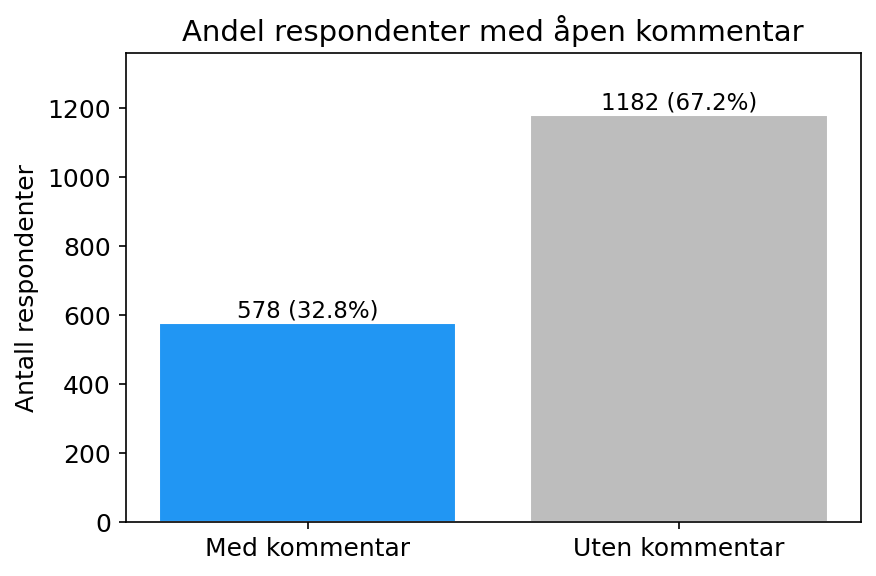

In [4]:
fig, ax = plt.subplots(figsize=(6, 4))
verdier = [n_kommentar, n_total - n_kommentar]
etiketter = ['Med kommentar', 'Uten kommentar']
farger = ['#2196F3', '#BDBDBD']
bars = ax.bar(etiketter, verdier, color=farger, edgecolor='white')
for bar, v in zip(bars, verdier):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 15,
            f'{v} ({v/n_total*100:.1f}%)', ha='center', fontsize=11)
ax.set_ylabel('Antall respondenter')
ax.set_title('Andel respondenter med åpen kommentar')
ax.set_ylim(0, max(verdier) * 1.15)
plt.tight_layout()
plt.show()

## 4. Mest brukte ord (alle)

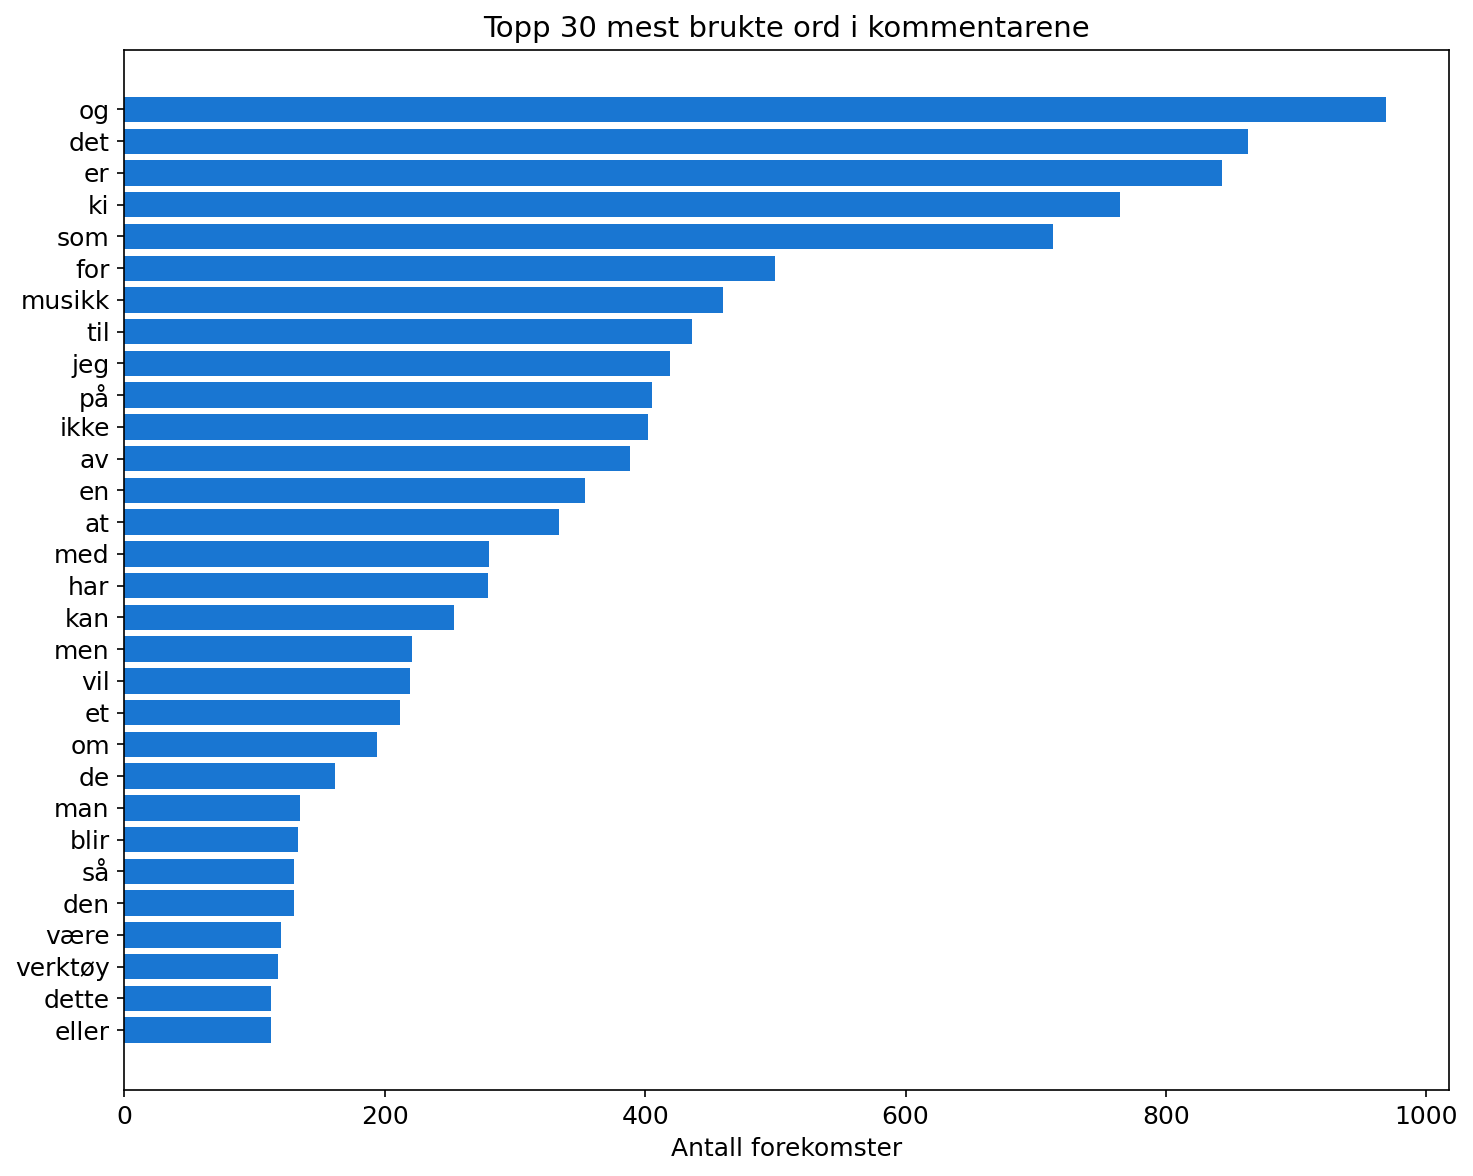

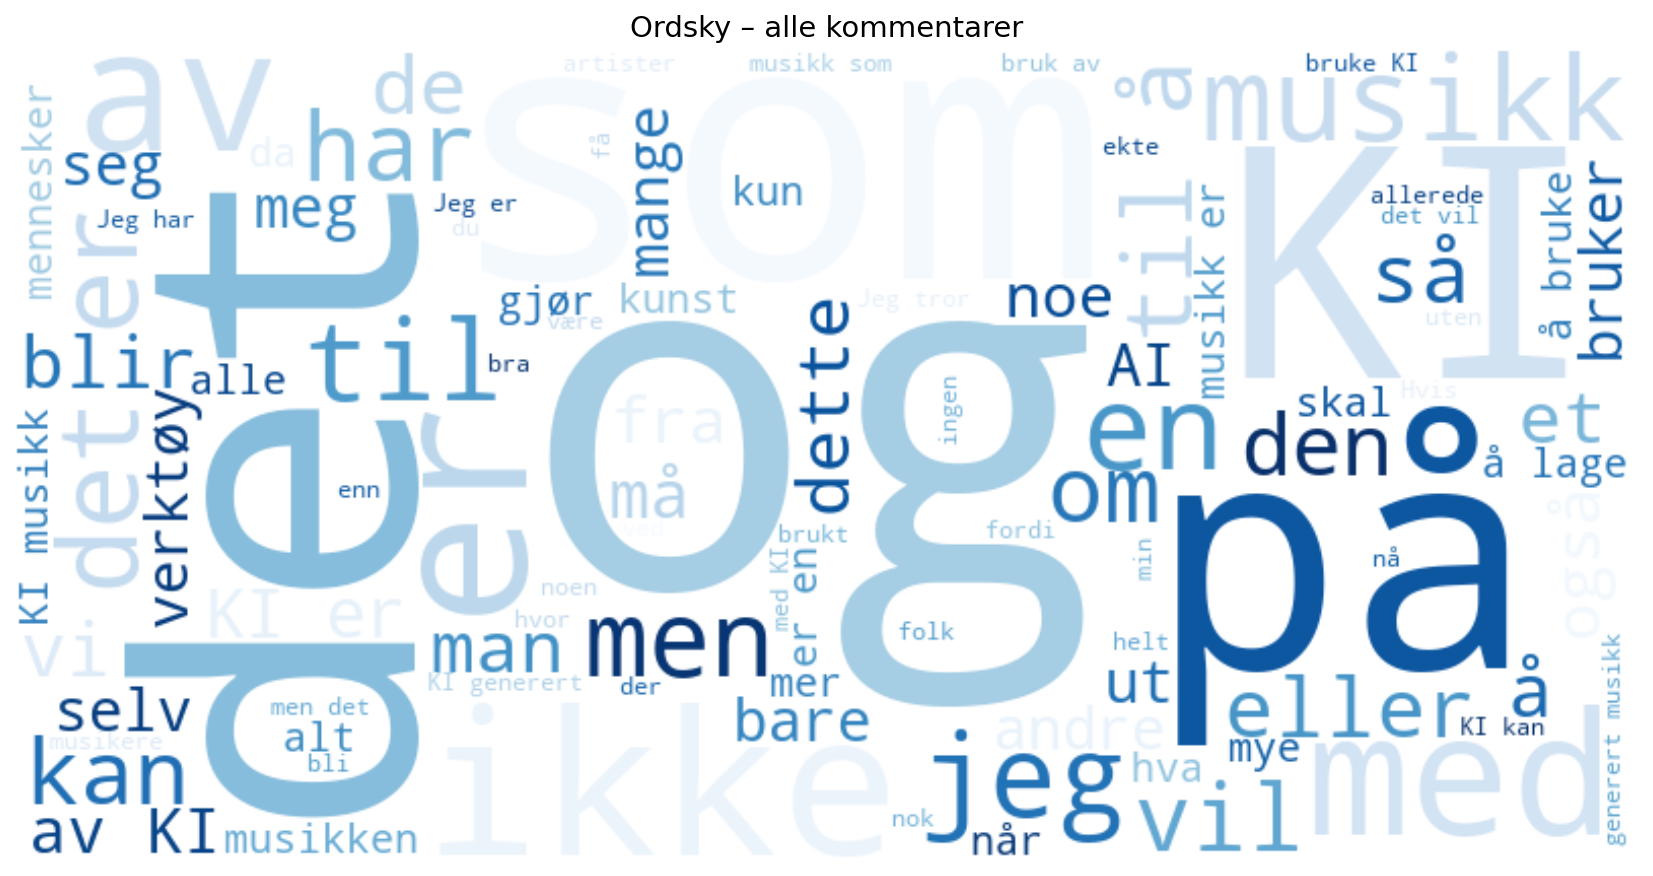

In [5]:
# Tokenisering
alle_ord = []
for tekst in kommentarer:
    tokens = re.findall(r'[a-zæøåA-ZÆØÅ]+', tekst.lower())
    alle_ord.extend(t for t in tokens if len(t) > 1)

ordtelling = Counter(alle_ord)
topp30 = ordtelling.most_common(30)

fig, ax = plt.subplots(figsize=(10, 8))
ord_list = [o for o, _ in topp30][::-1]
ant_list = [n for _, n in topp30][::-1]
ax.barh(ord_list, ant_list, color='#1976D2')
ax.set_xlabel('Antall forekomster')
ax.set_title('Topp 30 mest brukte ord i kommentarene')
plt.tight_layout()
plt.show()

# Ordsky
if HAS_WORDCLOUD:
    wc = WordCloud(width=800, height=400, background_color='white',
                   max_words=100, colormap='Blues').generate(' '.join(kommentarer))
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.imshow(wc, interpolation='bilinear')
    ax.axis('off')
    ax.set_title('Ordsky – alle kommentarer')
    plt.tight_layout()
    plt.show()
else:
    print('wordcloud ikke installert – hopper over ordsky.')

## 5. Mest brukte ord uten KI-termer og stoppord

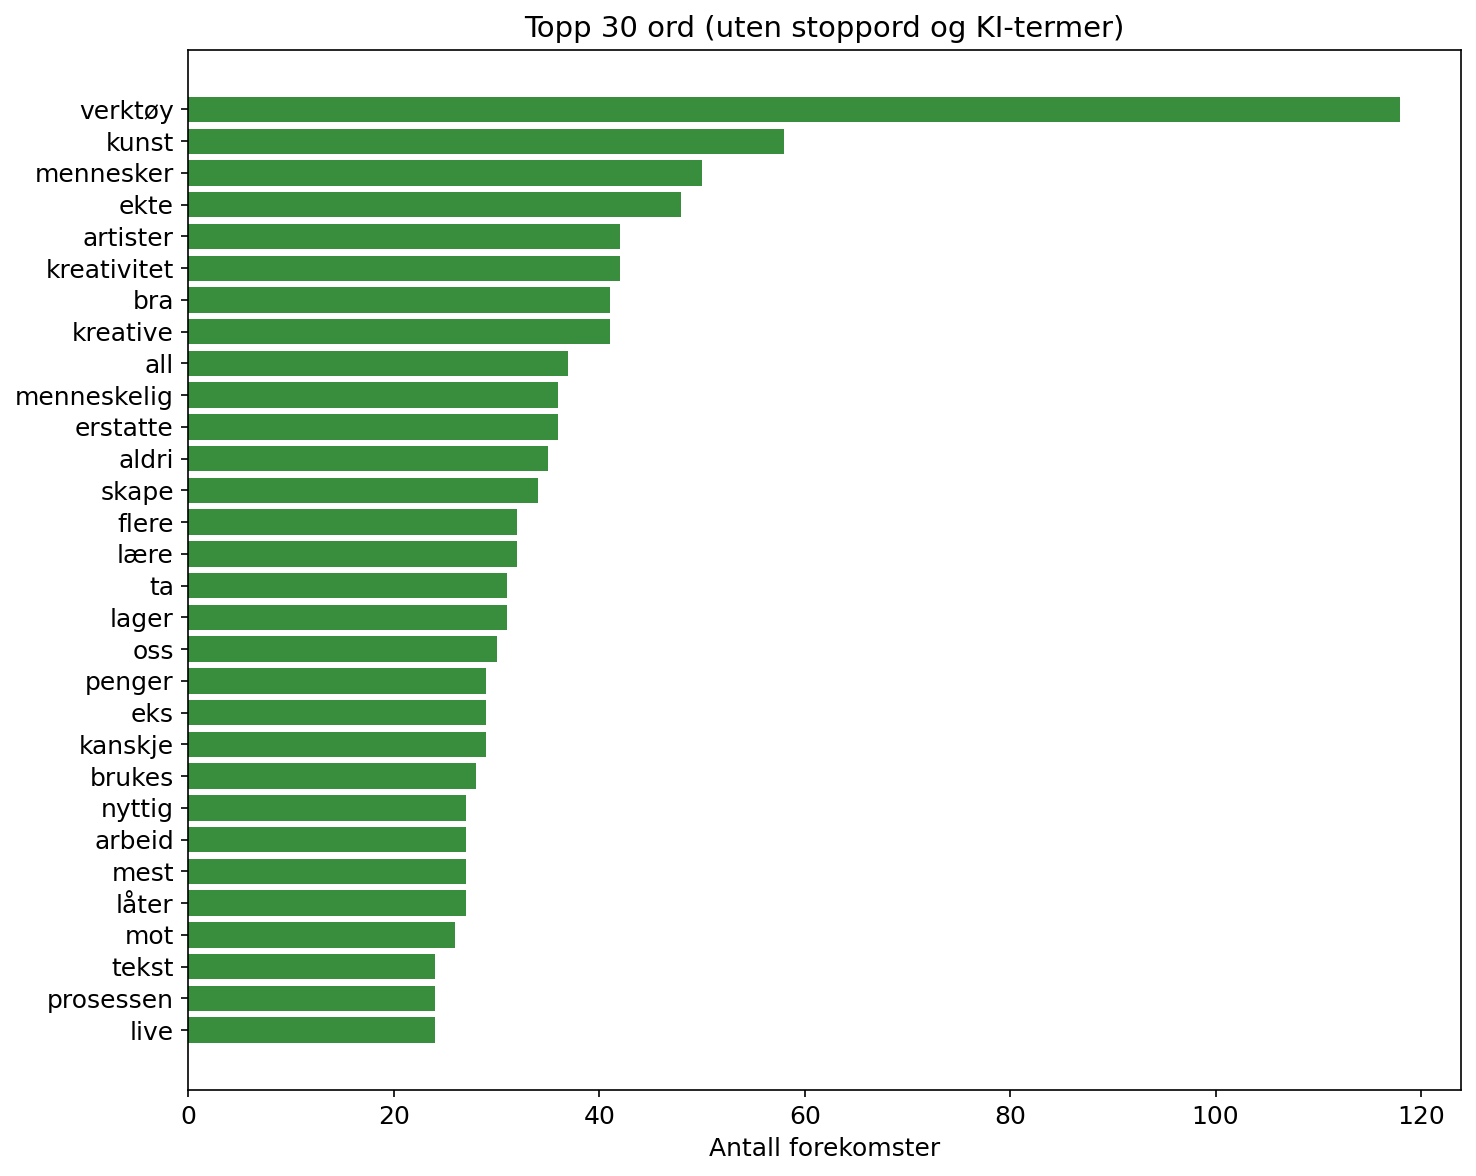

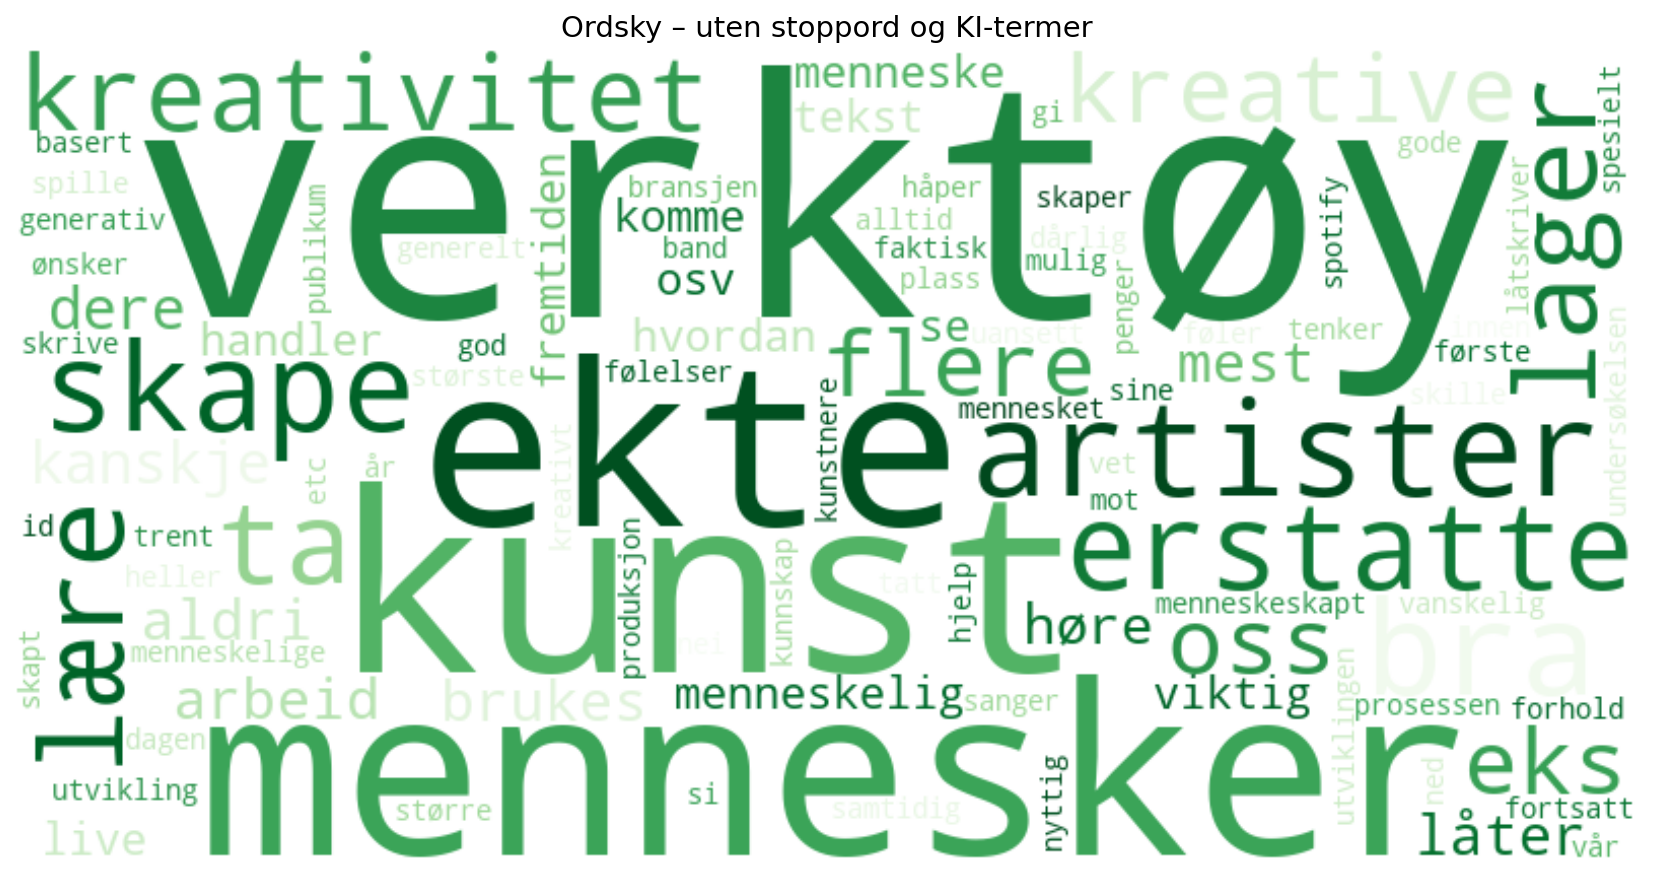

In [6]:
# Norsk stoppordliste + KI-termer
STOPPORD = {
    # Standard norske stoppord
    'og', 'i', 'er', 'det', 'som', 'en', 'et', 'til', 'for', 'på', 'av',
    'med', 'at', 'har', 'de', 'den', 'ikke', 'om', 'kan', 'vil', 'fra',
    'så', 'men', 'jeg', 'seg', 'vi', 'var', 'dette', 'alle', 'sin', 'skal',
    'over', 'eller', 'ble', 'blir', 'noe', 'også', 'andre', 'mange', 'der',
    'min', 'mitt', 'mine', 'han', 'hun', 'dem', 'enn', 'hva', 'når',
    'da', 'være', 'ha', 'meg', 'her', 'mer', 'ut', 'opp', 'inn', 'ved',
    'hvor', 'bare', 'noen', 'hvis', 'selv', 'hele', 'etter', 'mye',
    'du', 'deg', 'din', 'ditt', 'dine', 'nå', 'blitt', 'må', 'ville',
    'kunne', 'skulle', 'burde', 'hadde', 'vært', 'gjøre', 'gjør', 'gjorde',
    'veldig', 'helt', 'litt', 'mener', 'synes', 'tror',
    # Ekstra vanlige norske ord som ikke er innholdsrike
    'bli', 'bruker', 'brukt', 'bruke', 'bruk', 'man', 'folk', 'få',
    'kun', 'uten', 'ser', 'bør', 'fordi', 'ingen', 'ting', 'alt',
    'kommer', 'kommet', 'godt', 'gjerne', 'slik', 'både',
    'samt', 'rundt', 'gjennom', 'likevel', 'derfor', 'allerede',
    'siden', 'mens', 'før', 'under', 'mellom', 'nok', 'jo', 'vel',
    'svært', 'ganske', 'langt', 'stadig', 'videre', 'først', 'sammen',
    'igjen', 'enig', 'tar', 'går', 'gir', 'får', 'gjort',
    'sett', 'finnes', 'finne', 'nye', 'nytt', 'stor', 'stort', 'store',
    'lang', 'gamle', 'gammelt', 'lite', 'liten', 'mindre',
    'bedre', 'best', 'siste', 'annet', 'annen', 'samme', 'egen',
    'eget', 'egne', 'hver', 'hvert', 'hvilke', 'hvilken', 'hvilket',
    'disse', 'denne', 'sånn', 'slikt',
    'dag', 'tid', 'gang', 'del', 'måte', 'måter',
    'typ', 'type', 'typer', 'form', 'grad',
}

KI_TERMER = {
    'ki', 'ai', 'kunstig', 'intelligens', 'suno', 'chatgpt', 'chat',
    'gpt', 'udio', 'midjourney', 'copilot', 'openai', 'maskinlæring',
    # Kontekstord fra undersøkelsen
    'musikk', 'musikken', 'musikere', 'musiker', 'musikkbransjen',
    'lage', 'laget', 'lages', 'generert', 'generere',
}

fjern = STOPPORD | KI_TERMER

filtrerte_ord = [o for o in alle_ord if o not in fjern]
filtrer_telling = Counter(filtrerte_ord)
topp30_f = filtrer_telling.most_common(30)

fig, ax = plt.subplots(figsize=(10, 8))
ord_f = [o for o, _ in topp30_f][::-1]
ant_f = [n for _, n in topp30_f][::-1]
ax.barh(ord_f, ant_f, color='#388E3C')
ax.set_xlabel('Antall forekomster')
ax.set_title('Topp 30 ord (uten stoppord og KI-termer)')
plt.tight_layout()
plt.show()

# Filtrert ordsky
if HAS_WORDCLOUD:
    tekst_filtrert = ' '.join(filtrerte_ord)
    wc = WordCloud(width=800, height=400, background_color='white',
                   max_words=100, colormap='Greens').generate(tekst_filtrert)
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.imshow(wc, interpolation='bilinear')
    ax.axis('off')
    ax.set_title('Ordsky – uten stoppord og KI-termer')
    plt.tight_layout()
    plt.show()
else:
    print('wordcloud ikke installert – hopper over ordsky.')

## 6. Demografisk oversikt

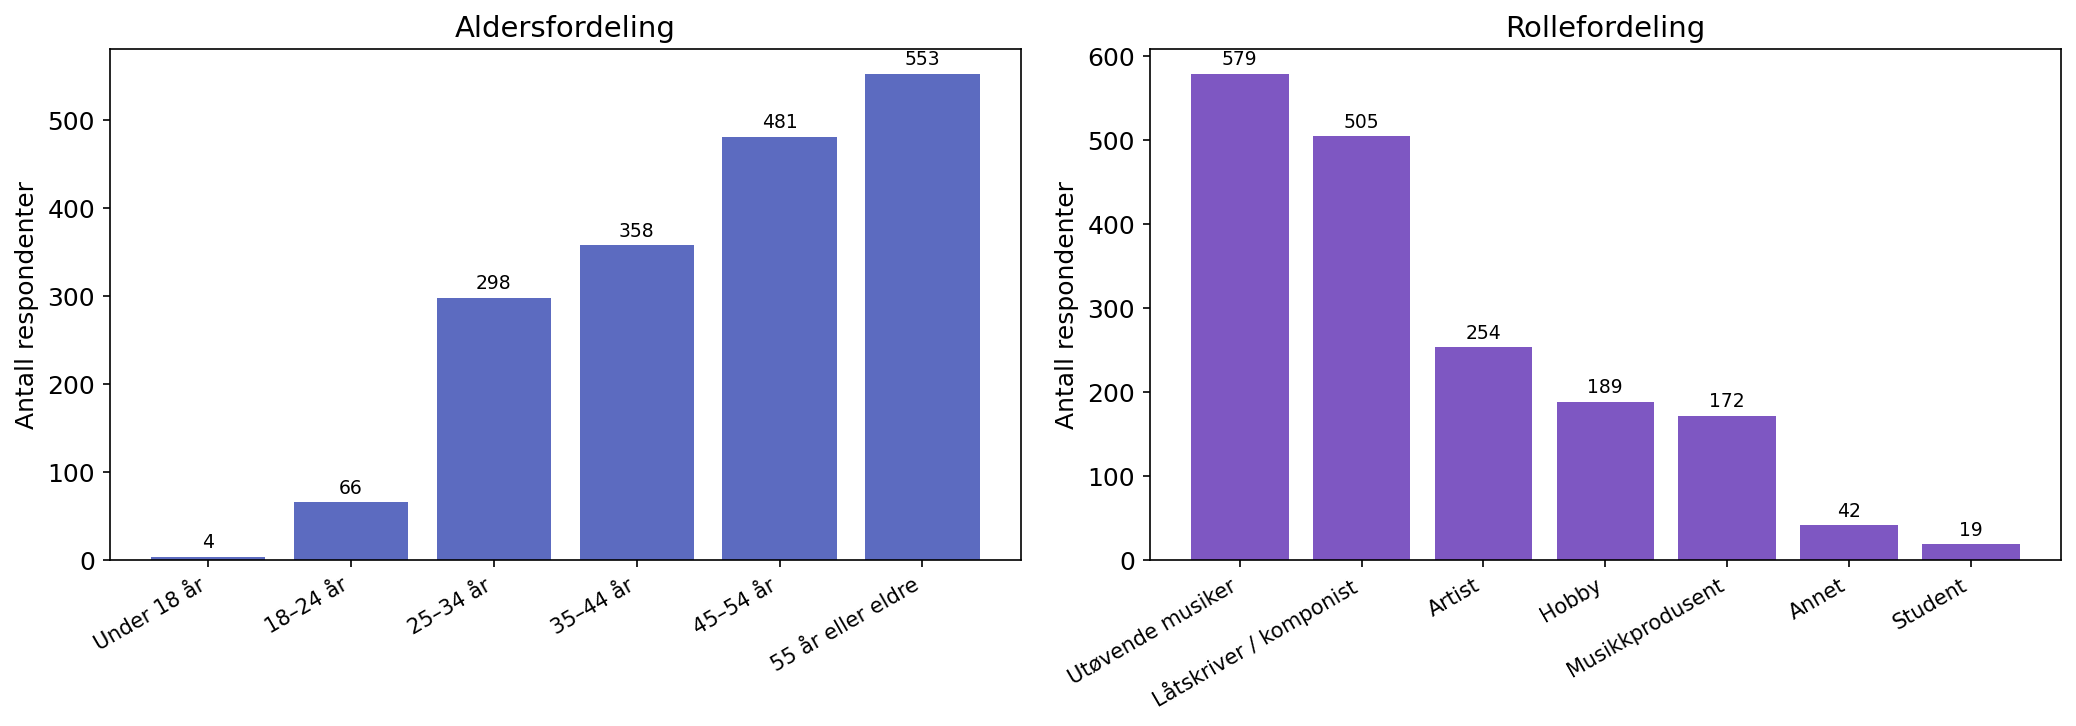

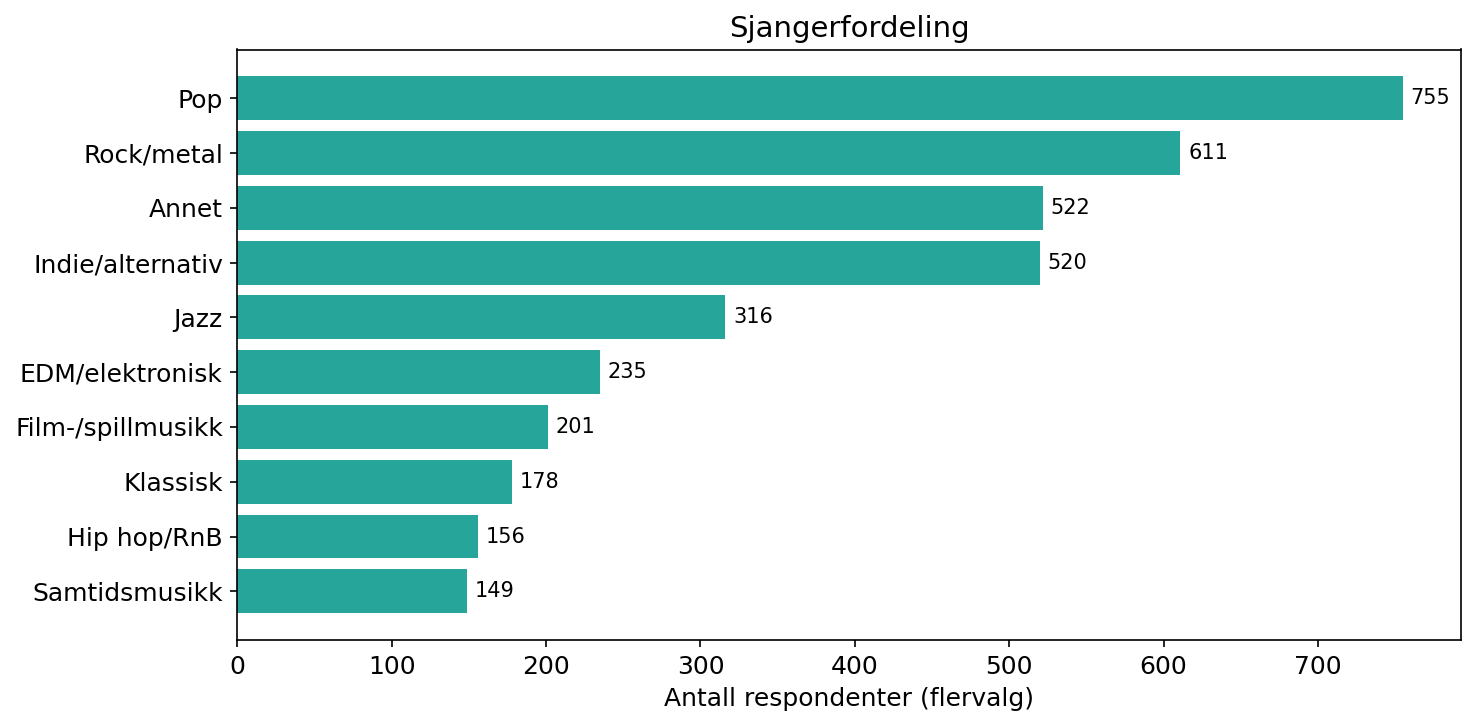

In [7]:
# Aldersfordeling
alder_orden = ['Under 18 år', '18–24 år', '25–34 år', '35–44 år', '45–54 år', '55 år eller eldre']
alder_tell = df['alder'].value_counts().reindex(alder_orden, fill_value=0)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Alder
ax = axes[0]
bars = ax.bar(range(len(alder_tell)), alder_tell.values, color='#5C6BC0')
ax.set_xticks(range(len(alder_tell)))
ax.set_xticklabels(alder_tell.index, rotation=30, ha='right', fontsize=10)
for bar, v in zip(bars, alder_tell.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10,
            str(v), ha='center', fontsize=9)
ax.set_ylabel('Antall respondenter')
ax.set_title('Aldersfordeling')

# Rolle
ax = axes[1]
rolle_tell = df['rolle'].value_counts()
bars = ax.bar(range(len(rolle_tell)), rolle_tell.values, color='#7E57C2')
ax.set_xticks(range(len(rolle_tell)))
ax.set_xticklabels(rolle_tell.index, rotation=30, ha='right', fontsize=10)
for bar, v in zip(bars, rolle_tell.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10,
            str(v), ha='center', fontsize=9)
ax.set_ylabel('Antall respondenter')
ax.set_title('Rollefordeling')

plt.tight_layout()
plt.show()

# Sjangerfordeling (flervalg – summer per sjanger)
sjanger_kol = [c for c in df.columns if c.startswith('sjanger_')]
sjanger_labels = {
    'sjanger_pop': 'Pop', 'sjanger_hiphop': 'Hip hop/RnB', 'sjanger_edm': 'EDM/elektronisk',
    'sjanger_rock': 'Rock/metal', 'sjanger_indie': 'Indie/alternativ',
    'sjanger_film': 'Film-/spillmusikk', 'sjanger_jazz': 'Jazz',
    'sjanger_klassisk': 'Klassisk', 'sjanger_samtid': 'Samtidsmusikk',
    'sjanger_annet': 'Annet'
}
sjanger_sum = df[sjanger_kol].sum().rename(sjanger_labels).sort_values()

fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.barh(sjanger_sum.index, sjanger_sum.values, color='#26A69A')
for bar, v in zip(bars, sjanger_sum.values):
    ax.text(bar.get_width() + 5, bar.get_y() + bar.get_height()/2,
            str(v), va='center', fontsize=10)
ax.set_xlabel('Antall respondenter (flervalg)')
ax.set_title('Sjangerfordeling')
plt.tight_layout()
plt.show()

## 7. KI-bruk etter aldersgruppe

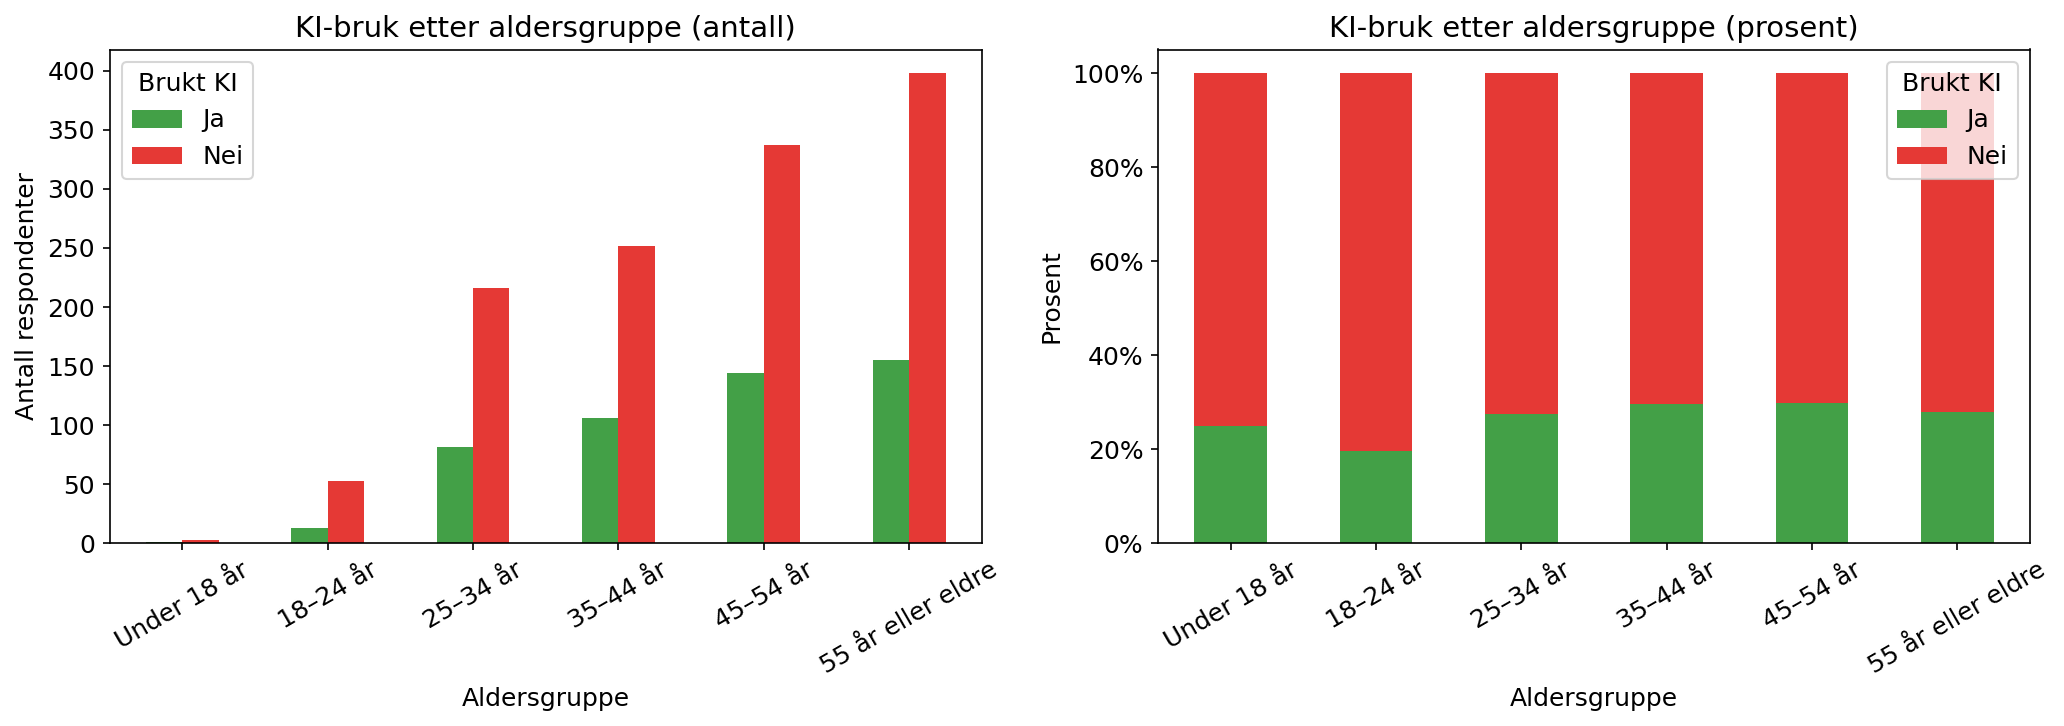


Bruksrate per aldersgruppe:
  Under 18 år: 25.0% bruker KI
  18–24 år: 19.7% bruker KI
  25–34 år: 27.5% bruker KI
  35–44 år: 29.6% bruker KI
  45–54 år: 29.9% bruker KI
  55 år eller eldre: 28.0% bruker KI


In [8]:
kryss = pd.crosstab(df['alder'], df['brukt_ki']).reindex(alder_orden)
kryss_pct = kryss.div(kryss.sum(axis=1), axis=0) * 100

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gruppert stolpe (antall)
kryss[['Ja', 'Nei']].plot(kind='bar', ax=axes[0], color=['#43A047', '#E53935'])
axes[0].set_title('KI-bruk etter aldersgruppe (antall)')
axes[0].set_ylabel('Antall respondenter')
axes[0].set_xlabel('Aldersgruppe')
axes[0].tick_params(axis='x', rotation=30)
axes[0].legend(title='Brukt KI')

# Stablet stolpe (prosent)
kryss_pct[['Ja', 'Nei']].plot(kind='bar', stacked=True, ax=axes[1],
                               color=['#43A047', '#E53935'])
axes[1].set_title('KI-bruk etter aldersgruppe (prosent)')
axes[1].set_ylabel('Prosent')
axes[1].set_xlabel('Aldersgruppe')
axes[1].tick_params(axis='x', rotation=30)
axes[1].legend(title='Brukt KI')
axes[1].yaxis.set_major_formatter(mticker.PercentFormatter())

plt.tight_layout()
plt.show()

print('\nBruksrate per aldersgruppe:')
for alder_gr in alder_orden:
    if alder_gr in kryss_pct.index:
        print(f'  {alder_gr}: {kryss_pct.loc[alder_gr, "Ja"]:.1f}% bruker KI')

## 8. KI-bruk etter sjanger

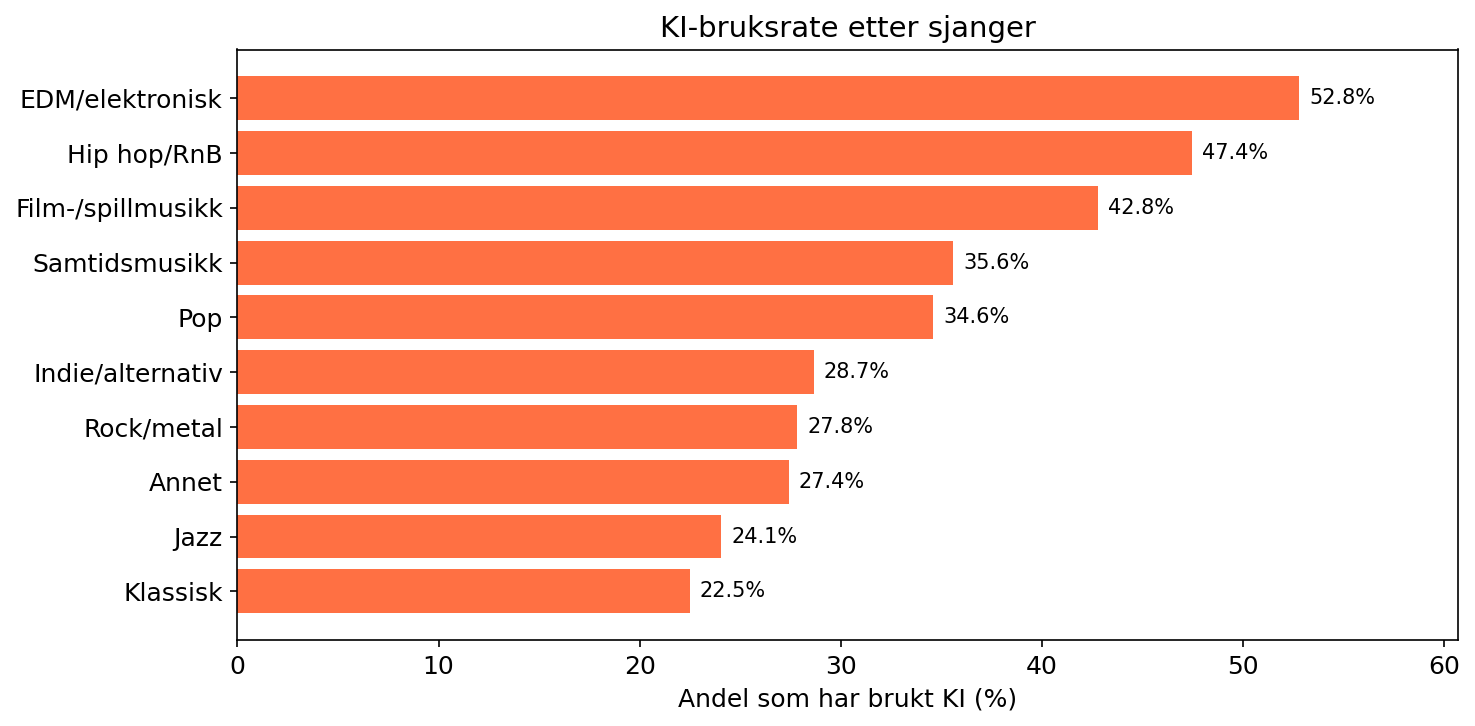

In [9]:
bruksrate = {}
for kol, label in sjanger_labels.items():
    mask = df[kol] == 1
    if mask.sum() > 0:
        rate = (df.loc[mask, 'brukt_ki'] == 'Ja').mean() * 100
        bruksrate[label] = rate

bruksrate_s = pd.Series(bruksrate).sort_values()

fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.barh(bruksrate_s.index, bruksrate_s.values, color='#FF7043')
for bar, v in zip(bars, bruksrate_s.values):
    ax.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2,
            f'{v:.1f}%', va='center', fontsize=10)
ax.set_xlabel('Andel som har brukt KI (%)')
ax.set_title('KI-bruksrate etter sjanger')
ax.set_xlim(0, bruksrate_s.max() * 1.15)
plt.tight_layout()
plt.show()

## 9. Holdninger til KI (Likert-skala)

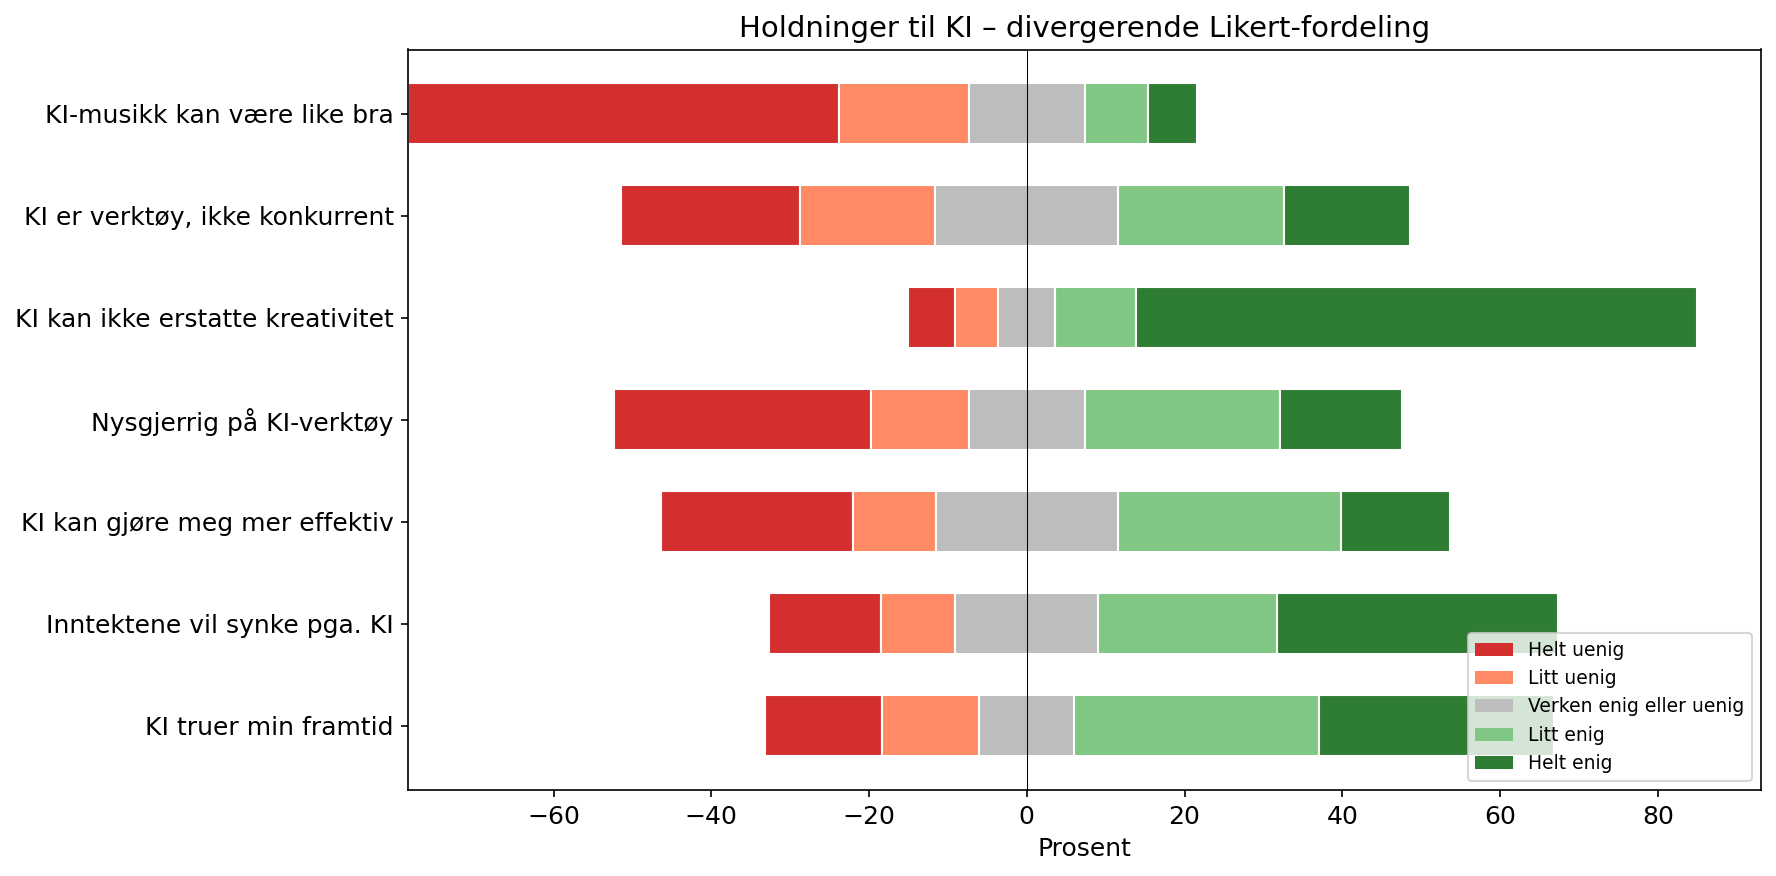

In [10]:
likert_kol = ['likert_trussel', 'likert_inntekt', 'likert_effektiv',
              'likert_nysgjerrig', 'likert_kreativitet', 'likert_verktoy', 'likert_likebra']

likert_labels = {
    'likert_trussel': 'KI truer min framtid',
    'likert_inntekt': 'Inntektene vil synke pga. KI',
    'likert_effektiv': 'KI kan gjøre meg mer effektiv',
    'likert_nysgjerrig': 'Nysgjerrig på KI-verktøy',
    'likert_kreativitet': 'KI kan ikke erstatte kreativitet',
    'likert_verktoy': 'KI er verktøy, ikke konkurrent',
    'likert_likebra': 'KI-musikk kan være like bra',
}

likert_order = ['Helt uenig', 'Litt uenig', 'Verken enig eller uenig', 'Litt enig', 'Helt enig']
likert_farger = ['#D32F2F', '#FF8A65', '#BDBDBD', '#81C784', '#2E7D32']

# Divergerende stablet stolpediagram
fig, ax = plt.subplots(figsize=(12, 6))
y_pos = np.arange(len(likert_kol))
labels_y = [likert_labels[k] for k in likert_kol]

for idx, kol in enumerate(likert_kol):
    tell = df[kol].value_counts().reindex(likert_order, fill_value=0)
    prosent = tell / tell.sum() * 100
    # Sentrer på nøytral
    nøytral = prosent.iloc[2]  # Verken enig eller uenig
    venstre_start = -(prosent.iloc[0] + prosent.iloc[1] + nøytral / 2)
    pos = venstre_start
    for j, (kat, pct) in enumerate(prosent.items()):
        ax.barh(idx, pct, left=pos, color=likert_farger[j], edgecolor='white', height=0.6)
        pos += pct

ax.set_yticks(y_pos)
ax.set_yticklabels(labels_y)
ax.set_xlabel('Prosent')
ax.set_title('Holdninger til KI – divergerende Likert-fordeling')
ax.axvline(0, color='black', linewidth=0.5)

# Legg til legende
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=c, label=l) for c, l in zip(likert_farger, likert_order)]
ax.legend(handles=legend_elements, loc='lower right', fontsize=9)

plt.tight_layout()
plt.show()

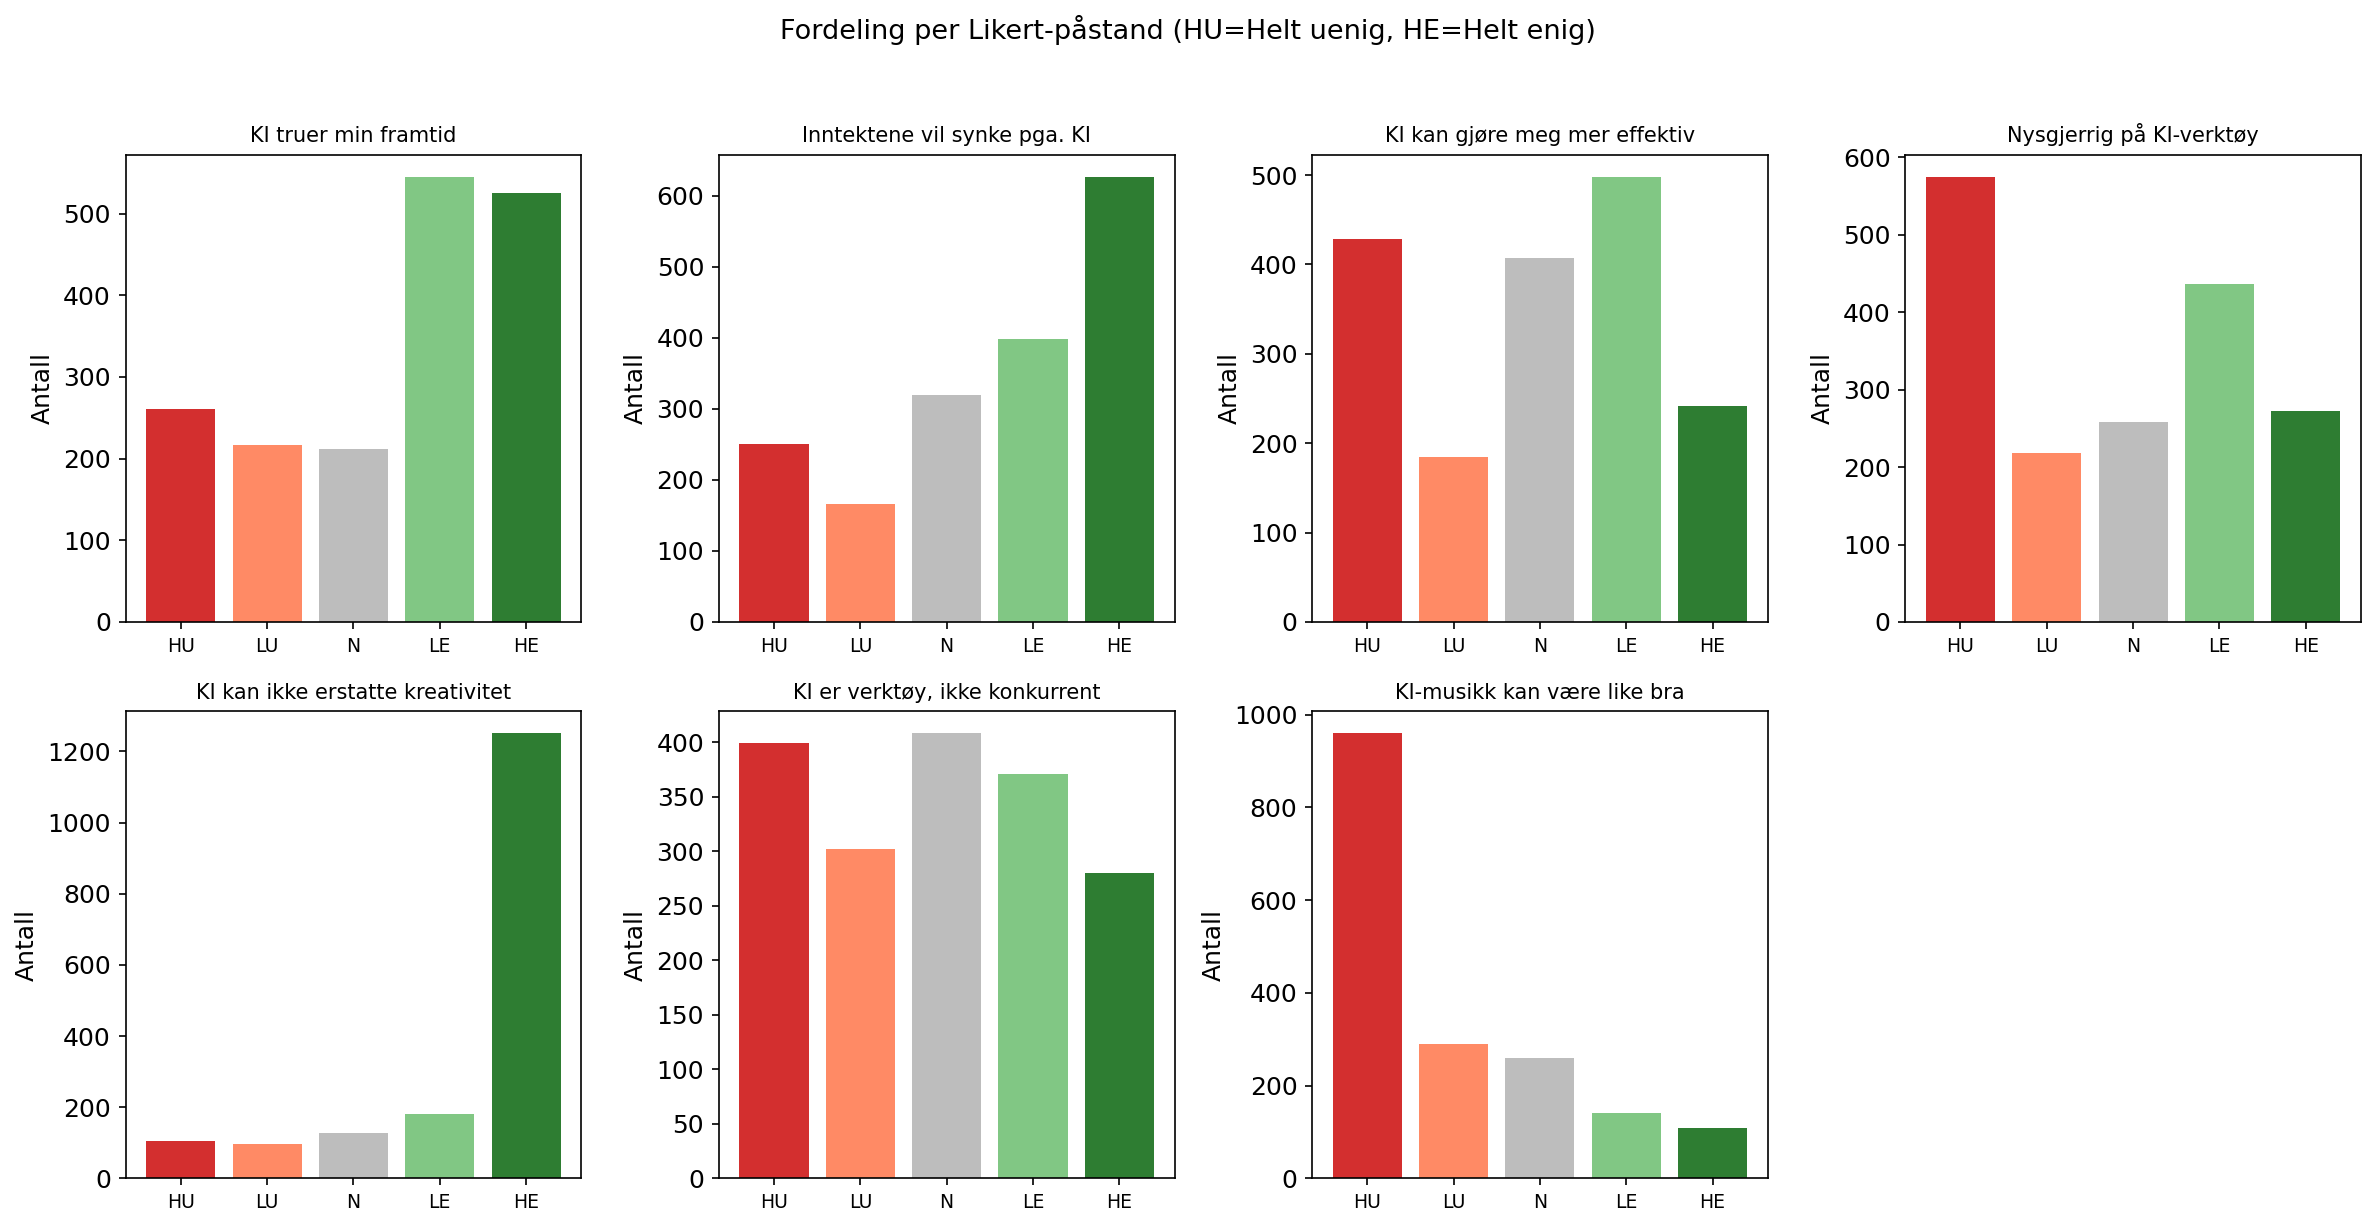

In [11]:
# Individuelle fordelinger i 2x4 rutenett
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes_flat = axes.flatten()

for i, kol in enumerate(likert_kol):
    ax = axes_flat[i]
    tell = df[kol].value_counts().reindex(likert_order, fill_value=0)
    ax.bar(range(5), tell.values, color=likert_farger)
    ax.set_xticks(range(5))
    ax.set_xticklabels(['HU', 'LU', 'N', 'LE', 'HE'], fontsize=9)
    ax.set_title(likert_labels[kol], fontsize=10, wrap=True)
    ax.set_ylabel('Antall')

# Skjul siste subplot (8. plass i 2x4)
axes_flat[7].axis('off')

fig.suptitle('Fordeling per Likert-påstand (HU=Helt uenig, HE=Helt enig)', fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

## 10. Bruksfrekvens blant KI-brukere

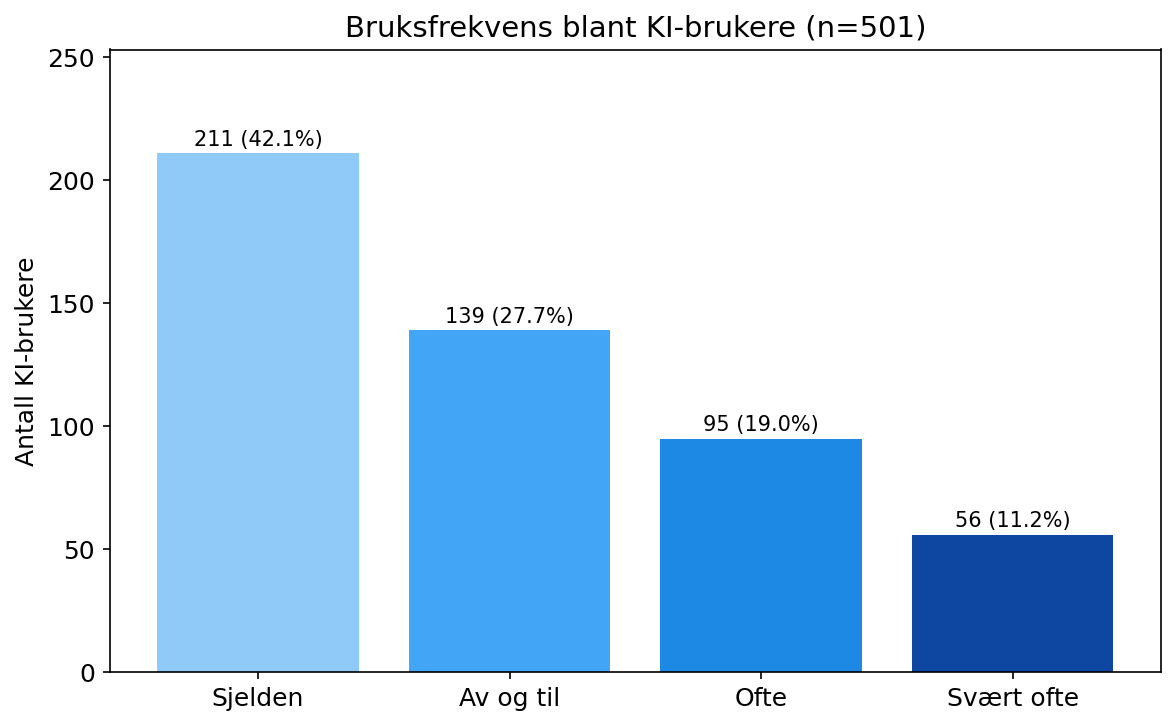

In [12]:
brukere = df[df['brukt_ki'] == 'Ja']

frekv_order = [
    'Sjelden (noen ganger i året)',
    'Av og til (ca. månedlig)',
    'Ofte (flere ganger i måneden)',
    'Svært ofte (nesten hver uke eller oftere)'
]
frekv_kort = ['Sjelden', 'Av og til', 'Ofte', 'Svært ofte']
frekv_tell = brukere['frekvens'].value_counts().reindex(frekv_order, fill_value=0)

fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(frekv_kort, frekv_tell.values, color=['#90CAF9', '#42A5F5', '#1E88E5', '#0D47A1'])
for bar, v in zip(bars, frekv_tell.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 3,
            f'{v} ({v/len(brukere)*100:.1f}%)', ha='center', fontsize=10)
ax.set_ylabel('Antall KI-brukere')
ax.set_title(f'Bruksfrekvens blant KI-brukere (n={len(brukere)})')
ax.set_ylim(0, frekv_tell.max() * 1.2)
plt.tight_layout()
plt.show()

## 11. Grunner til ikke-bruk

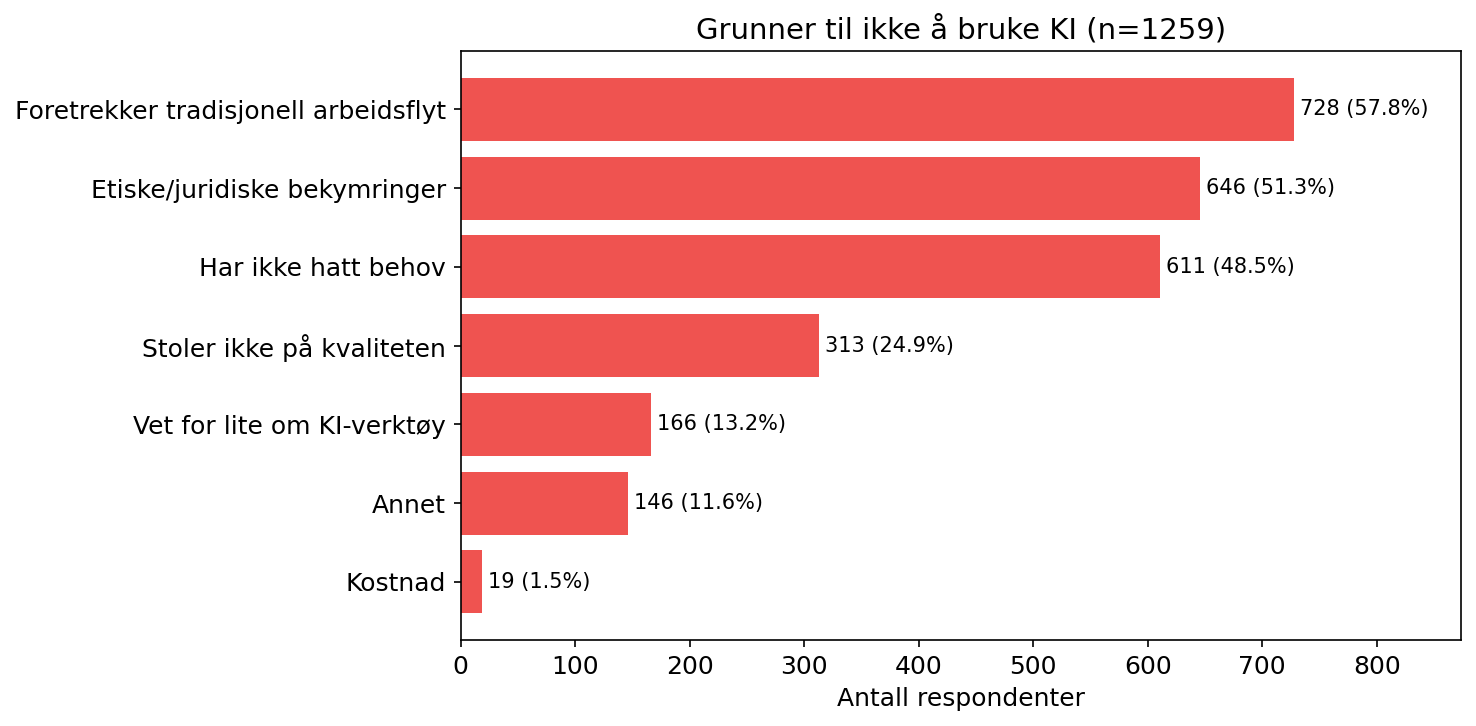

In [13]:
ikke_brukere = df[df['brukt_ki'] == 'Nei']

ikke_kol = ['ikke_behov', 'ikke_vite', 'ikke_trad', 'ikke_kvalitet',
            'ikke_etikk', 'ikke_kostnad', 'ikke_annet']
ikke_labels = {
    'ikke_behov': 'Har ikke hatt behov',
    'ikke_vite': 'Vet for lite om KI-verktøy',
    'ikke_trad': 'Foretrekker tradisjonell arbeidsflyt',
    'ikke_kvalitet': 'Stoler ikke på kvaliteten',
    'ikke_etikk': 'Etiske/juridiske bekymringer',
    'ikke_kostnad': 'Kostnad',
    'ikke_annet': 'Annet',
}

ikke_sum = ikke_brukere[ikke_kol].sum().rename(ikke_labels).sort_values()

fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.barh(ikke_sum.index, ikke_sum.values, color='#EF5350')
for bar, v in zip(bars, ikke_sum.values):
    ax.text(bar.get_width() + 5, bar.get_y() + bar.get_height()/2,
            f'{v} ({v/len(ikke_brukere)*100:.1f}%)', va='center', fontsize=10)
ax.set_xlabel('Antall respondenter')
ax.set_title(f'Grunner til ikke å bruke KI (n={len(ikke_brukere)})')
ax.set_xlim(0, ikke_sum.max() * 1.2)
plt.tight_layout()
plt.show()

## 12. Hva brukes KI til?

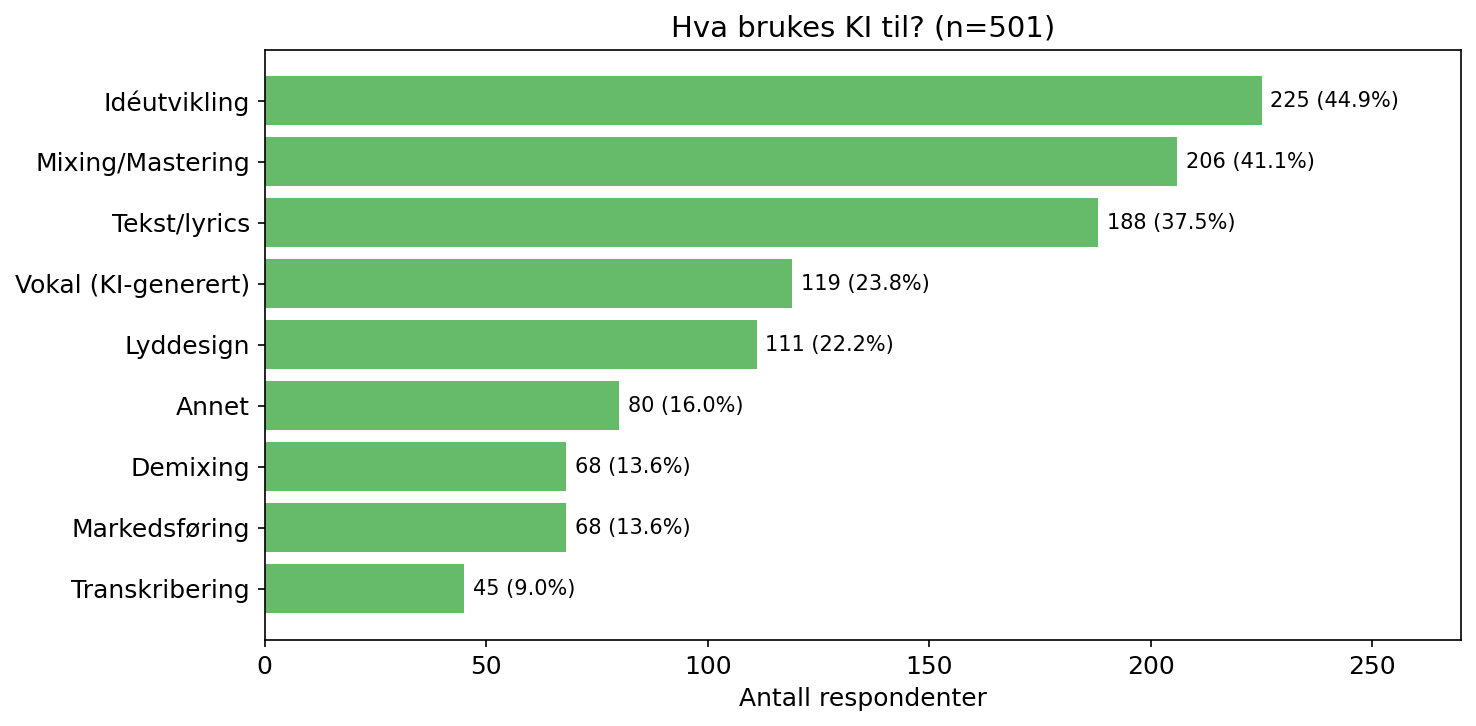

In [14]:
ki_kol = ['ki_ide', 'ki_tekst', 'ki_lyd', 'ki_mix', 'ki_marked',
          'ki_demix', 'ki_transkr', 'ki_vokal', 'ki_annet']
ki_labels = {
    'ki_ide': 'Idéutvikling',
    'ki_tekst': 'Tekst/lyrics',
    'ki_lyd': 'Lyddesign',
    'ki_mix': 'Mixing/Mastering',
    'ki_marked': 'Markedsføring',
    'ki_demix': 'Demixing',
    'ki_transkr': 'Transkribering',
    'ki_vokal': 'Vokal (KI-generert)',
    'ki_annet': 'Annet',
}

ki_sum = brukere[ki_kol].sum().rename(ki_labels).sort_values()

fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.barh(ki_sum.index, ki_sum.values, color='#66BB6A')
for bar, v in zip(bars, ki_sum.values):
    ax.text(bar.get_width() + 2, bar.get_y() + bar.get_height()/2,
            f'{int(v)} ({v/len(brukere)*100:.1f}%)', va='center', fontsize=10)
ax.set_xlabel('Antall respondenter')
ax.set_title(f'Hva brukes KI til? (n={len(brukere)})')
ax.set_xlim(0, ki_sum.max() * 1.2)
plt.tight_layout()
plt.show()

## 13. Framtidige intensjoner

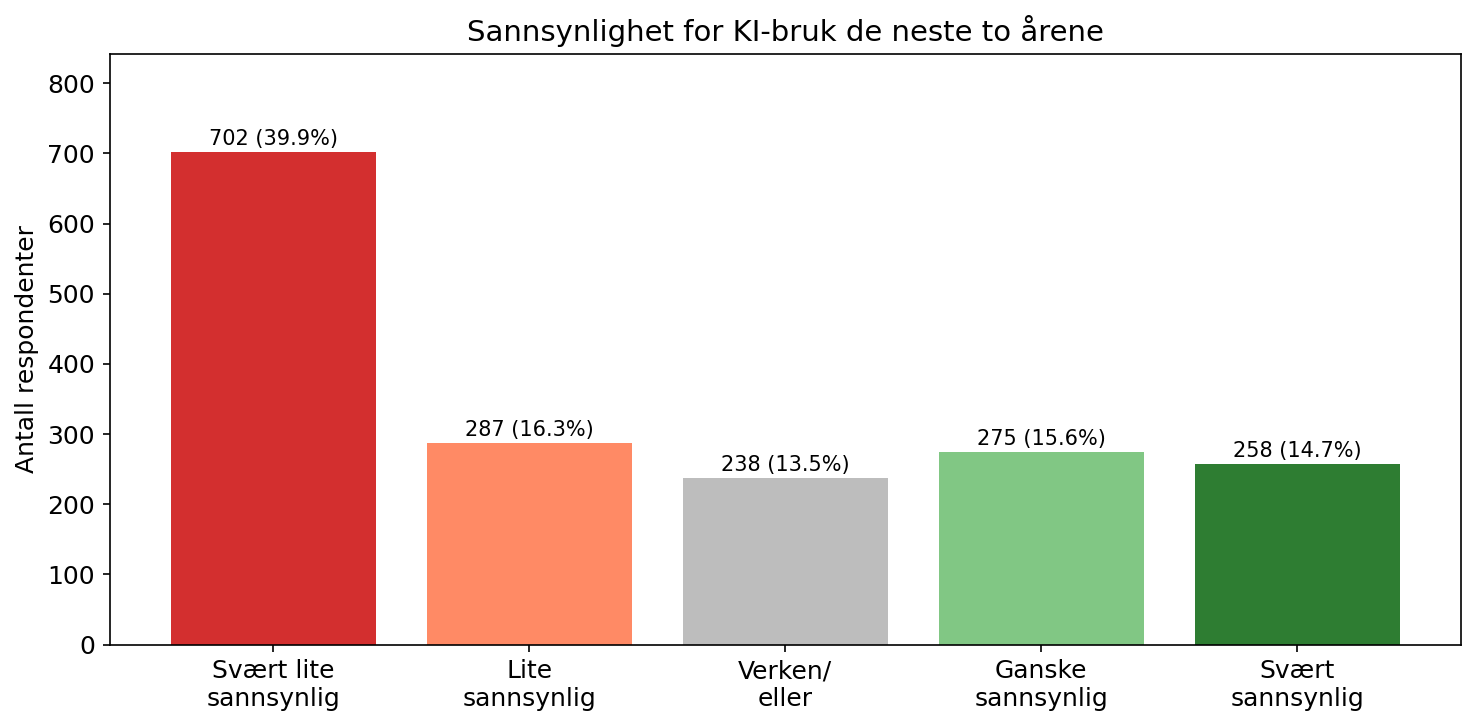

In [15]:
# Sannsynlighetsfordeling
sann_order = [
    'Svært lite sannsynlig', 'Lite sannsynlig',
    'Verken sannsynlig eller usannsynlig',
    'Ganske sannsynlig', 'Svært sannsynlig'
]
sann_kort = ['Svært lite\nsannsynlig', 'Lite\nsannsynlig', 'Verken/\neller',
             'Ganske\nsannsynlig', 'Svært\nsannsynlig']
sann_tell = df['sannsynlighet'].value_counts().reindex(sann_order, fill_value=0)
sann_farger = ['#D32F2F', '#FF8A65', '#BDBDBD', '#81C784', '#2E7D32']

fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.bar(sann_kort, sann_tell.values, color=sann_farger)
for bar, v in zip(bars, sann_tell.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10,
            f'{v} ({v/n_total*100:.1f}%)', ha='center', fontsize=10)
ax.set_ylabel('Antall respondenter')
ax.set_title('Sannsynlighet for KI-bruk de neste to årene')
ax.set_ylim(0, sann_tell.max() * 1.2)
plt.tight_layout()
plt.show()

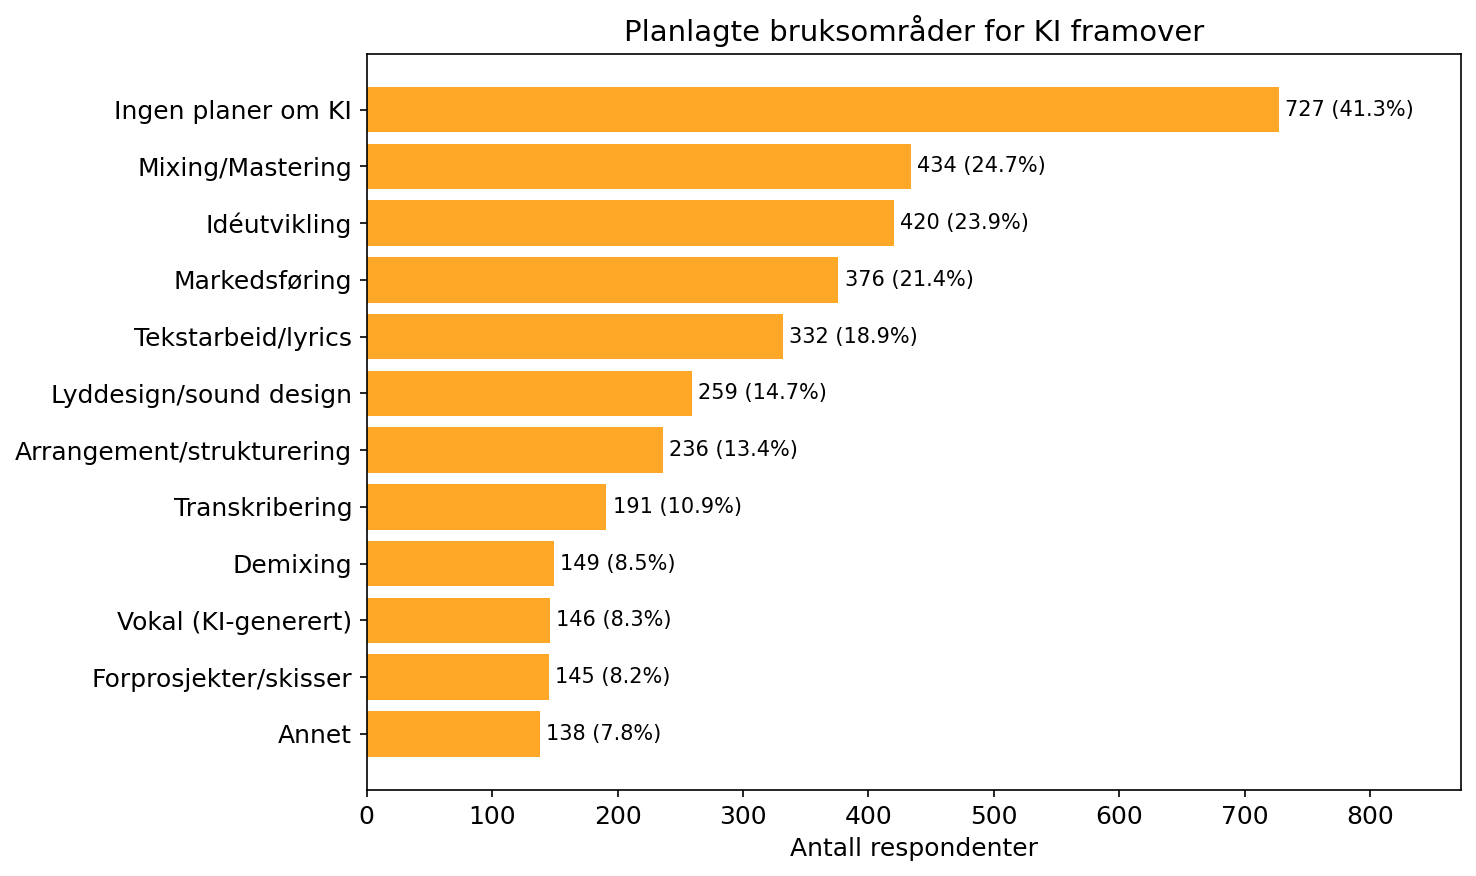

In [16]:
# Planlagte bruksområder
fram_kol = ['fram_ide', 'fram_arr', 'fram_lyd', 'fram_mix', 'fram_tekst',
            'fram_forprosjekt', 'fram_marked', 'fram_transkr', 'fram_vokal',
            'fram_demix', 'fram_annet', 'fram_ingen']
fram_labels = {
    'fram_ide': 'Idéutvikling',
    'fram_arr': 'Arrangement/strukturering',
    'fram_lyd': 'Lyddesign/sound design',
    'fram_mix': 'Mixing/Mastering',
    'fram_tekst': 'Tekstarbeid/lyrics',
    'fram_forprosjekt': 'Forprosjekter/skisser',
    'fram_marked': 'Markedsføring',
    'fram_transkr': 'Transkribering',
    'fram_vokal': 'Vokal (KI-generert)',
    'fram_demix': 'Demixing',
    'fram_annet': 'Annet',
    'fram_ingen': 'Ingen planer om KI',
}

fram_sum = df[fram_kol].sum().rename(fram_labels).sort_values()

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(fram_sum.index, fram_sum.values, color='#FFA726')
for bar, v in zip(bars, fram_sum.values):
    ax.text(bar.get_width() + 5, bar.get_y() + bar.get_height()/2,
            f'{int(v)} ({v/n_total*100:.1f}%)', va='center', fontsize=10)
ax.set_xlabel('Antall respondenter')
ax.set_title('Planlagte bruksområder for KI framover')
ax.set_xlim(0, fram_sum.max() * 1.2)
plt.tight_layout()
plt.show()

## 14. Holdninger: KI-brukere vs. ikke-brukere

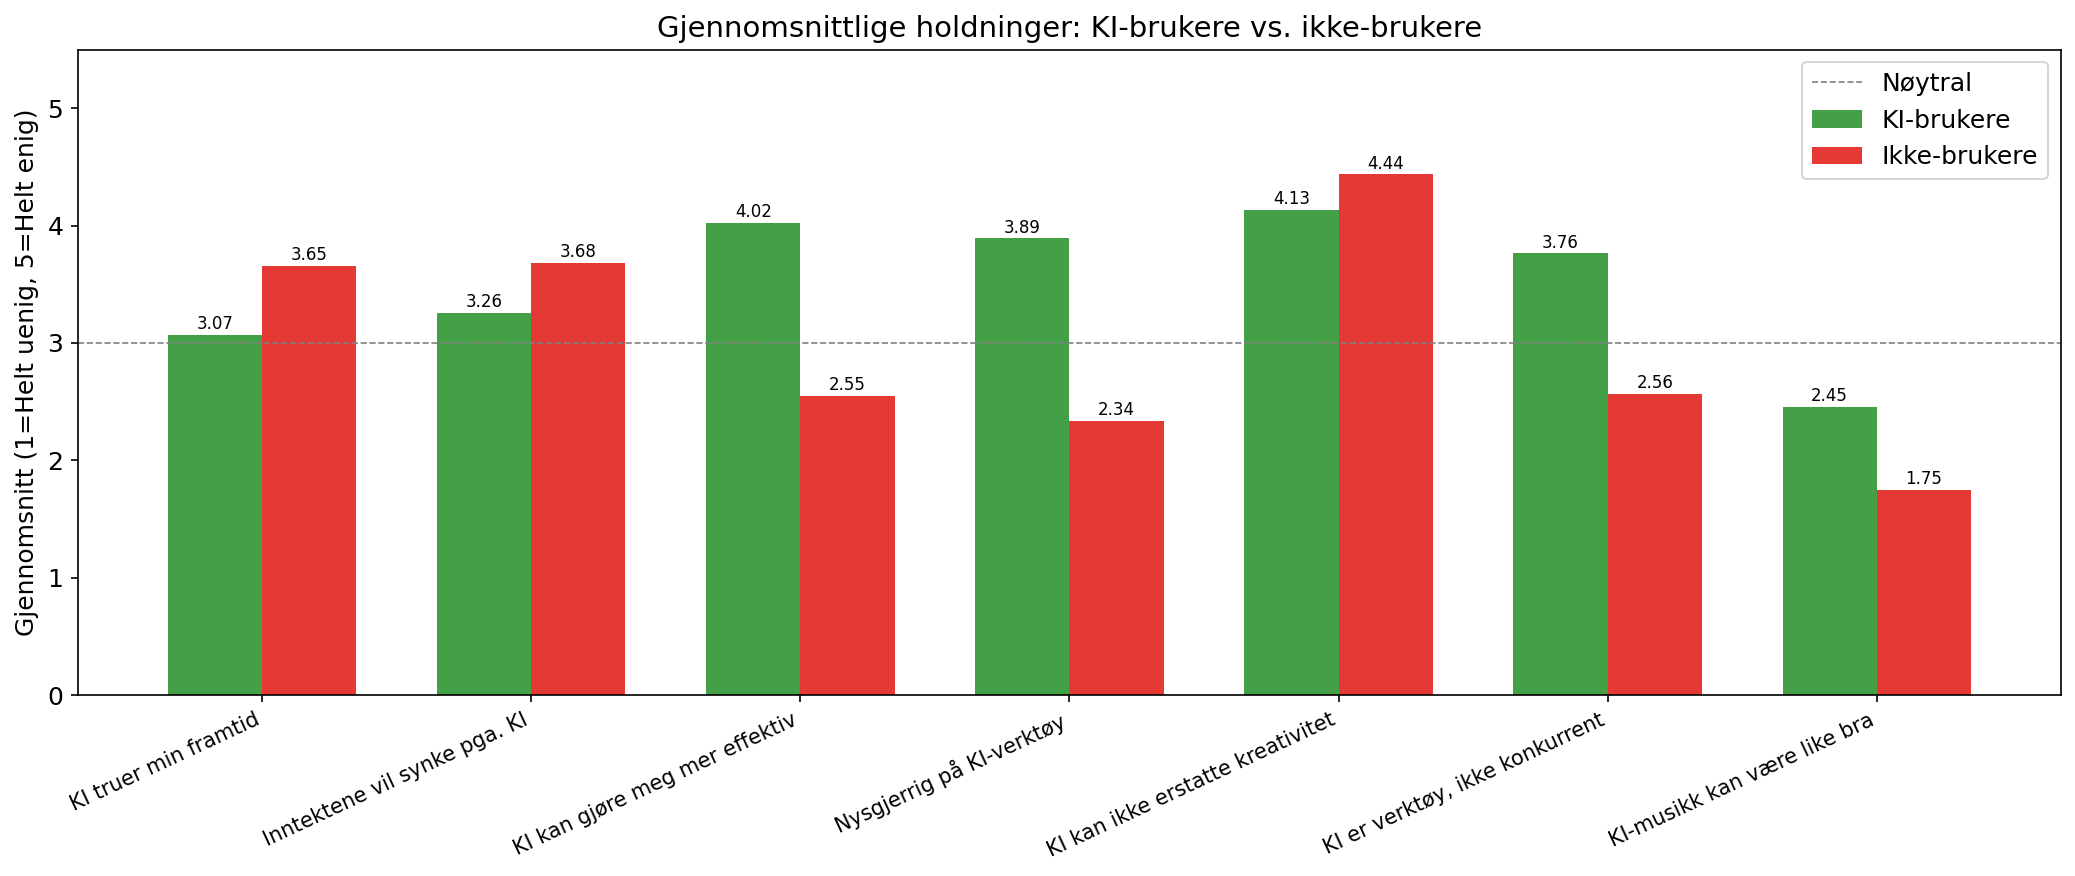

In [17]:
# Konverter Likert til numerisk 1-5
likert_map = {
    'Helt uenig': 1, 'Litt uenig': 2,
    'Verken enig eller uenig': 3,
    'Litt enig': 4, 'Helt enig': 5
}

for kol in likert_kol:
    df[kol + '_num'] = df[kol].map(likert_map)

likert_num_kol = [k + '_num' for k in likert_kol]
kort_labels = [likert_labels[k] for k in likert_kol]

gj_brukere = df[df['brukt_ki'] == 'Ja'][likert_num_kol].mean()
gj_ikke = df[df['brukt_ki'] == 'Nei'][likert_num_kol].mean()

x = np.arange(len(likert_kol))
bredde = 0.35

fig, ax = plt.subplots(figsize=(14, 6))
b1 = ax.bar(x - bredde/2, gj_brukere.values, bredde, label='KI-brukere', color='#43A047')
b2 = ax.bar(x + bredde/2, gj_ikke.values, bredde, label='Ikke-brukere', color='#E53935')

ax.set_xticks(x)
ax.set_xticklabels(kort_labels, rotation=25, ha='right', fontsize=10)
ax.set_ylabel('Gjennomsnitt (1=Helt uenig, 5=Helt enig)')
ax.set_title('Gjennomsnittlige holdninger: KI-brukere vs. ikke-brukere')
ax.set_ylim(0, 5.5)
ax.axhline(3, color='gray', linestyle='--', linewidth=0.8, label='Nøytral')
ax.legend()

# Verdi-etiketter
for bars in [b1, b2]:
    for bar in bars:
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
                f'{bar.get_height():.2f}', ha='center', fontsize=8)

plt.tight_layout()
plt.show()

## 15. Tematisk analyse av kommentarer

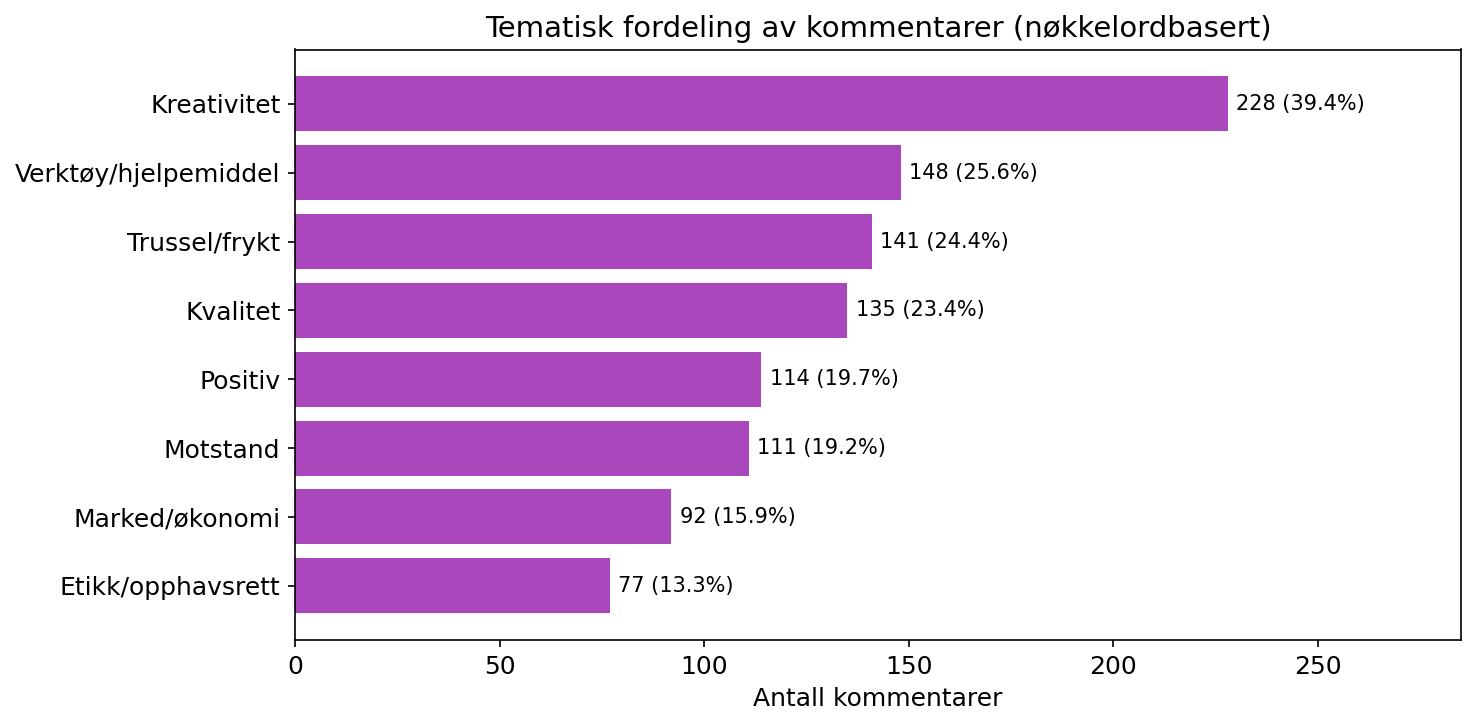


=== Eksempelkommentarer per tema ===

--- Etikk/opphavsrett (77 kommentarer) ---
  • Love it!
  • Det er klare begrensinger i dag med KI-verktøy, da spesielt KI-musikk generatorer. Derimot så vil denne teknologien trolig utvikle seg veldig fort, på...
  • Syns det er et hån mot artister og den kreative prosessen. KI er ikke etisk forsvarlig å bruke, på ingen måte. den forverrer klimakrisen og folk blir ...

--- Kreativitet (228 kommentarer) ---
  • Jeg vil bruke KI i samarbeid med komponister, hvor musikk delvis skapes av komponist, delvis av utøver, delvis av KI. KI er også nyttig i arbeid med s...
  • akademias tilnærming til KI er tendensiøs spiller på lag med amerikanske oligarker, og tar ikke innover seg virkeligheten som kunstnere og andre med l...
  • Jeg vil ikke røre det innenfor musikk, redd for å bli lat og miste mine kreative evner. Bruker det kun til det business relaterte. Søknader, kontrakte...

--- Kvalitet (135 kommentarer) ---
  • Det er klare begrensinger i dag med 

In [18]:
# Nøkkelordbasert klassifisering
temaer = {
    'Kreativitet': ['kreativ', 'skapende', 'skape', 'kunst', 'inspirasjon', 'fantasi',
                    'originalitet', 'kunstnerisk', 'uttrykk'],
    'Trussel/frykt': ['trussel', 'truer', 'redd', 'frykt', 'farlig', 'fare', 'erstatte',
                      'erstatning', 'overflødig', 'miste', 'arbeidsplasser', 'jobb'],
    'Etikk/opphavsrett': ['etikk', 'etisk', 'opphavsrett', 'rettigheter', 'tyveri', 'stjele',
                          'copyright', 'ulovlig', 'lovverk', 'regulering', 'lov', 'juridisk',
                          'moral', 'rettferdig'],
    'Verktøy/hjelpemiddel': ['verktøy', 'hjelpemiddel', 'hjelp', 'effektiv', 'nyttig',
                             'praktisk', 'tidsbesparende', 'automatisere', 'forenkle'],
    'Kvalitet': ['kvalitet', 'dårlig', 'bra', 'god', 'middelmådig', 'sjellløs', 'sjelløs',
                 'kjedelig', 'generisk', 'uoriginal', 'livløs'],
    'Motstand': ['nekter', 'aldri', 'mot', 'motstand', 'motstander', 'boikott',
                 'uakseptabelt', 'skandale', 'protest', 'ødelegge'],
    'Positiv': ['positivt', 'spennende', 'muligheter', 'potensial', 'framtid', 'utvikling',
                'innovasjon', 'interessant', 'åpen', 'gøy', 'kult', 'fantastisk'],
    'Marked/økonomi': ['marked', 'penger', 'inntekt', 'økonomi', 'verdikjede', 'streaming',
                       'spotif', 'priser', 'honorar', 'lønn', 'betalt', 'konkurranse'],
}

tema_teller = Counter()
tema_eksempler = {t: [] for t in temaer}

for kommentar in kommentarer:
    tekst_lower = kommentar.lower()
    for tema, nøkkelord in temaer.items():
        if any(n in tekst_lower for n in nøkkelord):
            tema_teller[tema] += 1
            if len(tema_eksempler[tema]) < 3:
                # Kutt lange kommentarer
                eksempel = kommentar[:150] + ('...' if len(kommentar) > 150 else '')
                tema_eksempler[tema].append(eksempel)

# Stolpediagram
tema_s = pd.Series(tema_teller).sort_values()

fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.barh(tema_s.index, tema_s.values, color='#AB47BC')
for bar, v in zip(bars, tema_s.values):
    ax.text(bar.get_width() + 2, bar.get_y() + bar.get_height()/2,
            f'{v} ({v/n_kommentar*100:.1f}%)', va='center', fontsize=10)
ax.set_xlabel('Antall kommentarer')
ax.set_title('Tematisk fordeling av kommentarer (nøkkelordbasert)')
ax.set_xlim(0, tema_s.max() * 1.25)
plt.tight_layout()
plt.show()

# Eksempelkommentarer
print('\n=== Eksempelkommentarer per tema ===\n')
for tema in sorted(temaer.keys()):
    print(f'--- {tema} ({tema_teller[tema]} kommentarer) ---')
    for eks in tema_eksempler[tema]:
        print(f'  • {eks}')
    print()

In [19]:
# Valgfritt: TF-IDF + KMeans-klynger
if HAS_SKLEARN and len(kommentarer) >= 20:
    print('=== TF-IDF + KMeans klyngeanalyse ===')
    n_clusters = 6

    norske_stopp = list(STOPPORD | KI_TERMER)
    vectorizer = TfidfVectorizer(max_features=500, stop_words=norske_stopp,
                                 min_df=3, max_df=0.8)
    X = vectorizer.fit_transform(kommentarer)

    km = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    labels = km.fit_predict(X)

    feature_names = vectorizer.get_feature_names_out()
    print(f'\nAntall klynger: {n_clusters}\n')
    for i in range(n_clusters):
        topp_idx = km.cluster_centers_[i].argsort()[-8:][::-1]
        topp_ord = [feature_names[j] for j in topp_idx]
        n_i = (labels == i).sum()
        print(f'Klynge {i+1} (n={n_i}): {", ".join(topp_ord)}')
else:
    if not HAS_SKLEARN:
        print('sklearn ikke installert – hopper over klyngeanalyse.')
    else:
        print('For få kommentarer for klyngeanalyse.')

=== TF-IDF + KMeans klyngeanalyse ===

Antall klynger: 6

Klynge 1 (n=281): brukes, flere, følelser, fremtiden, plass, mennesker, bekymret, vanskelig
Klynge 2 (n=65): ekte, artister, penger, spotify, tjene, eks, mennesker, plattformer
Klynge 3 (n=90): verktøy, kreative, lære, prosessen, nyttig, oss, brukes, hjelpemiddel
Klynge 4 (n=72): kunst, kreativitet, erstatte, menneskelig, all, aldri, hjelp, blant
Klynge 5 (n=55): bra, skape, dårlig, verktøy, lager, produkt, ferdig, gi
Klynge 6 (n=15): nei, kunnskap, uetisk, tenke, ødelegger, 100, ute, kreativt


## 16. Oppsummering

In [20]:
# Nøkkelstatistikk
n_ja = (df['brukt_ki'] == 'Ja').sum()
n_nei = (df['brukt_ki'] == 'Nei').sum()

# Mest populære bruksområde
ki_topp = brukere[ki_kol].sum().rename(ki_labels).sort_values(ascending=False)
topp_bruk = ki_topp.index[0]

# Mest populære grunn til ikke-bruk
ikke_topp = ikke_brukere[ikke_kol].sum().rename(ikke_labels).sort_values(ascending=False)
topp_ikke = ikke_topp.index[0]

# Fremtidig bruk
n_sannsynlig = ((df['sannsynlighet'] == 'Ganske sannsynlig') |
                (df['sannsynlighet'] == 'Svært sannsynlig')).sum()

print('=' * 60)
print('OPPSUMMERING – KI-spørreundersøkelse blant norske musikere')
print('=' * 60)
print(f'\nTotalt antall respondenter: {n_total}')
print(f'\nKI-bruk:')
print(f'  Har brukt KI:     {n_ja} ({n_ja/n_total*100:.1f}%)')
print(f'  Har ikke brukt KI: {n_nei} ({n_nei/n_total*100:.1f}%)')
print(f'\nMest populære bruksområde: {topp_bruk} ({int(ki_topp.iloc[0])} respondenter)')
print(f'Vanligste grunn til ikke-bruk: {topp_ikke} ({int(ikke_topp.iloc[0])} respondenter)')
print(f'\nSannsynlig KI-bruk neste 2 år: {n_sannsynlig} ({n_sannsynlig/n_total*100:.1f}%)')
print(f'\nKommentarer: {n_kommentar} av {n_total} ({andel:.1f}%) ga en åpen kommentar')
print(f'\nAldersfordeling:')
for alder_gr in alder_orden:
    n = alder_tell.get(alder_gr, 0)
    print(f'  {alder_gr}: {n} ({n/n_total*100:.1f}%)')
print('\n' + '=' * 60)

OPPSUMMERING – KI-spørreundersøkelse blant norske musikere

Totalt antall respondenter: 1760

KI-bruk:
  Har brukt KI:     501 (28.5%)
  Har ikke brukt KI: 1259 (71.5%)

Mest populære bruksområde: Idéutvikling (225 respondenter)
Vanligste grunn til ikke-bruk: Foretrekker tradisjonell arbeidsflyt (728 respondenter)

Sannsynlig KI-bruk neste 2 år: 533 (30.3%)

Kommentarer: 578 av 1760 (32.8%) ga en åpen kommentar

Aldersfordeling:
  Under 18 år: 4 (0.2%)
  18–24 år: 66 (3.8%)
  25–34 år: 298 (16.9%)
  35–44 år: 358 (20.3%)
  45–54 år: 481 (27.3%)
  55 år eller eldre: 553 (31.4%)

